https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

# Potential Plot
Minimization of the following:

$$\bar{u}_\text{pot} = \frac{U}{E_J} = -\big[ \alpha\cos(\varphi_{02}) + \cos(\varphi_{03}) + \cos(\varphi_{01}) + \\
+ \cos(\varphi_{02} - \varphi_{01} - L) + \cos(\varphi_{02} - \varphi_{03} + R)\big]
$$

In [1]:
from utils.array_stacker import ArrayStacker
from kernels.potential_minimum_searcher import PotentialMinimumSearcher
from kernels.potential_evaluator import PotentialEvaluator
from functions.potential import potential_function_cuda
from common import plotter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numba.cuda.cudadrv.devicearray import DeviceNDArray
from numba import cuda
import numpy as np
import math
import itertools
from collections import defaultdict
from typing import Tuple, List


pi = math.pi
sin = np.sin
cos = np.cos

plt.style.use('my_official')

# Parameters of the simulation

In [2]:
NUMBER_OF_PHI_POINTS = 100
NUMBER_OF_FIELD_POINTS = 2000
NUMBER_OF_FIELD_POINTS_PER_RUN = 20
NUMBER_OF_FIELD_RUNS = (
    NUMBER_OF_FIELD_POINTS - 1
) // NUMBER_OF_FIELD_POINTS_PER_RUN + 1
ALPHA = 1
LOWER = -0.5
UPPER = 1.5

lr_array = np.linspace(LOWER * 2 * pi, UPPER * 2 * pi, NUMBER_OF_FIELD_POINTS)
phixx_array = np.linspace(-pi, pi, NUMBER_OF_PHI_POINTS)

# Create kernels to cuda

In [3]:
BLOCKS_PER_GRID = (NUMBER_OF_FIELD_POINTS_PER_RUN, NUMBER_OF_FIELD_POINTS_PER_RUN)

potential_evaluator = PotentialEvaluator(NUMBER_OF_PHI_POINTS, potential_function_cuda)
THREADS_PER_BLOCK_potential_evaluation = potential_evaluator.allocate_max_threads(8)

potential_minimum_searcher = PotentialMinimumSearcher(NUMBER_OF_PHI_POINTS)
THREADS_PER_BLOCK_potential_search = potential_minimum_searcher.allocate_max_threads()

🐳 Allocating           THREADS_PER_BLOCK = (8, 8, 8)
🐳 Allocating           THREADS_PER_BLOCK = (32, 32)


# Execution

## Allocate arrays on GPU

In [4]:
DEVICE_lr_array = cuda.to_device(lr_array)
DEVICE_phixx_array = cuda.to_device(phixx_array)
DEVICE_potential_array = cuda.device_array(
    shape=(
        NUMBER_OF_FIELD_POINTS_PER_RUN,
        NUMBER_OF_FIELD_POINTS_PER_RUN,
        NUMBER_OF_PHI_POINTS,
        NUMBER_OF_PHI_POINTS,
        NUMBER_OF_PHI_POINTS,
    ),
    dtype=np.float64,
)
DEVICE_grid_search_result_array = cuda.device_array(
    shape=(NUMBER_OF_FIELD_POINTS_PER_RUN, NUMBER_OF_FIELD_POINTS_PER_RUN, 4),
    dtype=np.float32,
)

## Run kernels on each quadrant

In [5]:
# Go through teach of the field section and evaluate ##########################
quadrants = defaultdict(lambda: [[None] * NUMBER_OF_FIELD_RUNS for i in range(0, NUMBER_OF_FIELD_RUNS)])
for (L_RUN, R_RUN) in itertools.product(
    range(0, NUMBER_OF_FIELD_RUNS), range(0, NUMBER_OF_FIELD_RUNS)
):
    L_OFFSET = int(L_RUN * NUMBER_OF_FIELD_POINTS_PER_RUN)
    R_OFFSET = int(R_RUN * NUMBER_OF_FIELD_POINTS_PER_RUN)
    print(
        f"🦑 Running (L={L_RUN}/{NUMBER_OF_FIELD_RUNS - 1}, L_offset={L_OFFSET}), (R={R_RUN}/{NUMBER_OF_FIELD_RUNS - 1}, R_offset={R_OFFSET})"
    )
    potential_evaluator.kernel[BLOCKS_PER_GRID, THREADS_PER_BLOCK_potential_evaluation](
        DEVICE_phixx_array,
        DEVICE_lr_array,
        L_OFFSET,
        R_OFFSET,
        ALPHA,
        DEVICE_potential_array,
    )
    
    potential_minimum_searcher.kernel[
        BLOCKS_PER_GRID, THREADS_PER_BLOCK_potential_search
    ](DEVICE_potential_array, DEVICE_grid_search_result_array)
        
    grid_search_result_array = DEVICE_grid_search_result_array.copy_to_host()
    
    quadrants["potential"][L_RUN][R_RUN] = grid_search_result_array[:,:,0]
    quadrants["phi01"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,1].astype(int)]
    quadrants["phi02"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,2].astype(int)]
    quadrants["phi03"][L_RUN][R_RUN] = phixx_array[grid_search_result_array[:,:,3].astype(int)]

🦑 Running (L=0/99, L_offset=0), (R=0/99, R_offset=0)
🦑 Running (L=0/99, L_offset=0), (R=1/99, R_offset=20)
🦑 Running (L=0/99, L_offset=0), (R=2/99, R_offset=40)
🦑 Running (L=0/99, L_offset=0), (R=3/99, R_offset=60)
🦑 Running (L=0/99, L_offset=0), (R=4/99, R_offset=80)
🦑 Running (L=0/99, L_offset=0), (R=5/99, R_offset=100)
🦑 Running (L=0/99, L_offset=0), (R=6/99, R_offset=120)
🦑 Running (L=0/99, L_offset=0), (R=7/99, R_offset=140)
🦑 Running (L=0/99, L_offset=0), (R=8/99, R_offset=160)
🦑 Running (L=0/99, L_offset=0), (R=9/99, R_offset=180)
🦑 Running (L=0/99, L_offset=0), (R=10/99, R_offset=200)
🦑 Running (L=0/99, L_offset=0), (R=11/99, R_offset=220)
🦑 Running (L=0/99, L_offset=0), (R=12/99, R_offset=240)
🦑 Running (L=0/99, L_offset=0), (R=13/99, R_offset=260)
🦑 Running (L=0/99, L_offset=0), (R=14/99, R_offset=280)
🦑 Running (L=0/99, L_offset=0), (R=15/99, R_offset=300)
🦑 Running (L=0/99, L_offset=0), (R=16/99, R_offset=320)
🦑 Running (L=0/99, L_offset=0), (R=17/99, R_offset=340)
🦑 Runnin

🦑 Running (L=1/99, L_offset=20), (R=43/99, R_offset=860)
🦑 Running (L=1/99, L_offset=20), (R=44/99, R_offset=880)
🦑 Running (L=1/99, L_offset=20), (R=45/99, R_offset=900)
🦑 Running (L=1/99, L_offset=20), (R=46/99, R_offset=920)
🦑 Running (L=1/99, L_offset=20), (R=47/99, R_offset=940)
🦑 Running (L=1/99, L_offset=20), (R=48/99, R_offset=960)
🦑 Running (L=1/99, L_offset=20), (R=49/99, R_offset=980)
🦑 Running (L=1/99, L_offset=20), (R=50/99, R_offset=1000)
🦑 Running (L=1/99, L_offset=20), (R=51/99, R_offset=1020)
🦑 Running (L=1/99, L_offset=20), (R=52/99, R_offset=1040)
🦑 Running (L=1/99, L_offset=20), (R=53/99, R_offset=1060)
🦑 Running (L=1/99, L_offset=20), (R=54/99, R_offset=1080)
🦑 Running (L=1/99, L_offset=20), (R=55/99, R_offset=1100)
🦑 Running (L=1/99, L_offset=20), (R=56/99, R_offset=1120)
🦑 Running (L=1/99, L_offset=20), (R=57/99, R_offset=1140)
🦑 Running (L=1/99, L_offset=20), (R=58/99, R_offset=1160)
🦑 Running (L=1/99, L_offset=20), (R=59/99, R_offset=1180)
🦑 Running (L=1/99, L_

🦑 Running (L=2/99, L_offset=40), (R=84/99, R_offset=1680)
🦑 Running (L=2/99, L_offset=40), (R=85/99, R_offset=1700)
🦑 Running (L=2/99, L_offset=40), (R=86/99, R_offset=1720)
🦑 Running (L=2/99, L_offset=40), (R=87/99, R_offset=1740)
🦑 Running (L=2/99, L_offset=40), (R=88/99, R_offset=1760)
🦑 Running (L=2/99, L_offset=40), (R=89/99, R_offset=1780)
🦑 Running (L=2/99, L_offset=40), (R=90/99, R_offset=1800)
🦑 Running (L=2/99, L_offset=40), (R=91/99, R_offset=1820)
🦑 Running (L=2/99, L_offset=40), (R=92/99, R_offset=1840)
🦑 Running (L=2/99, L_offset=40), (R=93/99, R_offset=1860)
🦑 Running (L=2/99, L_offset=40), (R=94/99, R_offset=1880)
🦑 Running (L=2/99, L_offset=40), (R=95/99, R_offset=1900)
🦑 Running (L=2/99, L_offset=40), (R=96/99, R_offset=1920)
🦑 Running (L=2/99, L_offset=40), (R=97/99, R_offset=1940)
🦑 Running (L=2/99, L_offset=40), (R=98/99, R_offset=1960)
🦑 Running (L=2/99, L_offset=40), (R=99/99, R_offset=1980)
🦑 Running (L=3/99, L_offset=60), (R=0/99, R_offset=0)
🦑 Running (L=3/99,

🦑 Running (L=4/99, L_offset=80), (R=25/99, R_offset=500)
🦑 Running (L=4/99, L_offset=80), (R=26/99, R_offset=520)
🦑 Running (L=4/99, L_offset=80), (R=27/99, R_offset=540)
🦑 Running (L=4/99, L_offset=80), (R=28/99, R_offset=560)
🦑 Running (L=4/99, L_offset=80), (R=29/99, R_offset=580)
🦑 Running (L=4/99, L_offset=80), (R=30/99, R_offset=600)
🦑 Running (L=4/99, L_offset=80), (R=31/99, R_offset=620)
🦑 Running (L=4/99, L_offset=80), (R=32/99, R_offset=640)
🦑 Running (L=4/99, L_offset=80), (R=33/99, R_offset=660)
🦑 Running (L=4/99, L_offset=80), (R=34/99, R_offset=680)
🦑 Running (L=4/99, L_offset=80), (R=35/99, R_offset=700)
🦑 Running (L=4/99, L_offset=80), (R=36/99, R_offset=720)
🦑 Running (L=4/99, L_offset=80), (R=37/99, R_offset=740)
🦑 Running (L=4/99, L_offset=80), (R=38/99, R_offset=760)
🦑 Running (L=4/99, L_offset=80), (R=39/99, R_offset=780)
🦑 Running (L=4/99, L_offset=80), (R=40/99, R_offset=800)
🦑 Running (L=4/99, L_offset=80), (R=41/99, R_offset=820)
🦑 Running (L=4/99, L_offset=80)

🦑 Running (L=5/99, L_offset=100), (R=65/99, R_offset=1300)
🦑 Running (L=5/99, L_offset=100), (R=66/99, R_offset=1320)
🦑 Running (L=5/99, L_offset=100), (R=67/99, R_offset=1340)
🦑 Running (L=5/99, L_offset=100), (R=68/99, R_offset=1360)
🦑 Running (L=5/99, L_offset=100), (R=69/99, R_offset=1380)
🦑 Running (L=5/99, L_offset=100), (R=70/99, R_offset=1400)
🦑 Running (L=5/99, L_offset=100), (R=71/99, R_offset=1420)
🦑 Running (L=5/99, L_offset=100), (R=72/99, R_offset=1440)
🦑 Running (L=5/99, L_offset=100), (R=73/99, R_offset=1460)
🦑 Running (L=5/99, L_offset=100), (R=74/99, R_offset=1480)
🦑 Running (L=5/99, L_offset=100), (R=75/99, R_offset=1500)
🦑 Running (L=5/99, L_offset=100), (R=76/99, R_offset=1520)
🦑 Running (L=5/99, L_offset=100), (R=77/99, R_offset=1540)
🦑 Running (L=5/99, L_offset=100), (R=78/99, R_offset=1560)
🦑 Running (L=5/99, L_offset=100), (R=79/99, R_offset=1580)
🦑 Running (L=5/99, L_offset=100), (R=80/99, R_offset=1600)
🦑 Running (L=5/99, L_offset=100), (R=81/99, R_offset=162

🦑 Running (L=7/99, L_offset=140), (R=3/99, R_offset=60)
🦑 Running (L=7/99, L_offset=140), (R=4/99, R_offset=80)
🦑 Running (L=7/99, L_offset=140), (R=5/99, R_offset=100)
🦑 Running (L=7/99, L_offset=140), (R=6/99, R_offset=120)
🦑 Running (L=7/99, L_offset=140), (R=7/99, R_offset=140)
🦑 Running (L=7/99, L_offset=140), (R=8/99, R_offset=160)
🦑 Running (L=7/99, L_offset=140), (R=9/99, R_offset=180)
🦑 Running (L=7/99, L_offset=140), (R=10/99, R_offset=200)
🦑 Running (L=7/99, L_offset=140), (R=11/99, R_offset=220)
🦑 Running (L=7/99, L_offset=140), (R=12/99, R_offset=240)
🦑 Running (L=7/99, L_offset=140), (R=13/99, R_offset=260)
🦑 Running (L=7/99, L_offset=140), (R=14/99, R_offset=280)
🦑 Running (L=7/99, L_offset=140), (R=15/99, R_offset=300)
🦑 Running (L=7/99, L_offset=140), (R=16/99, R_offset=320)
🦑 Running (L=7/99, L_offset=140), (R=17/99, R_offset=340)
🦑 Running (L=7/99, L_offset=140), (R=18/99, R_offset=360)
🦑 Running (L=7/99, L_offset=140), (R=19/99, R_offset=380)
🦑 Running (L=7/99, L_of

🦑 Running (L=8/99, L_offset=160), (R=42/99, R_offset=840)
🦑 Running (L=8/99, L_offset=160), (R=43/99, R_offset=860)
🦑 Running (L=8/99, L_offset=160), (R=44/99, R_offset=880)
🦑 Running (L=8/99, L_offset=160), (R=45/99, R_offset=900)
🦑 Running (L=8/99, L_offset=160), (R=46/99, R_offset=920)
🦑 Running (L=8/99, L_offset=160), (R=47/99, R_offset=940)
🦑 Running (L=8/99, L_offset=160), (R=48/99, R_offset=960)
🦑 Running (L=8/99, L_offset=160), (R=49/99, R_offset=980)
🦑 Running (L=8/99, L_offset=160), (R=50/99, R_offset=1000)
🦑 Running (L=8/99, L_offset=160), (R=51/99, R_offset=1020)
🦑 Running (L=8/99, L_offset=160), (R=52/99, R_offset=1040)
🦑 Running (L=8/99, L_offset=160), (R=53/99, R_offset=1060)
🦑 Running (L=8/99, L_offset=160), (R=54/99, R_offset=1080)
🦑 Running (L=8/99, L_offset=160), (R=55/99, R_offset=1100)
🦑 Running (L=8/99, L_offset=160), (R=56/99, R_offset=1120)
🦑 Running (L=8/99, L_offset=160), (R=57/99, R_offset=1140)
🦑 Running (L=8/99, L_offset=160), (R=58/99, R_offset=1160)
🦑 Run

🦑 Running (L=9/99, L_offset=180), (R=80/99, R_offset=1600)
🦑 Running (L=9/99, L_offset=180), (R=81/99, R_offset=1620)
🦑 Running (L=9/99, L_offset=180), (R=82/99, R_offset=1640)
🦑 Running (L=9/99, L_offset=180), (R=83/99, R_offset=1660)
🦑 Running (L=9/99, L_offset=180), (R=84/99, R_offset=1680)
🦑 Running (L=9/99, L_offset=180), (R=85/99, R_offset=1700)
🦑 Running (L=9/99, L_offset=180), (R=86/99, R_offset=1720)
🦑 Running (L=9/99, L_offset=180), (R=87/99, R_offset=1740)
🦑 Running (L=9/99, L_offset=180), (R=88/99, R_offset=1760)
🦑 Running (L=9/99, L_offset=180), (R=89/99, R_offset=1780)
🦑 Running (L=9/99, L_offset=180), (R=90/99, R_offset=1800)
🦑 Running (L=9/99, L_offset=180), (R=91/99, R_offset=1820)
🦑 Running (L=9/99, L_offset=180), (R=92/99, R_offset=1840)
🦑 Running (L=9/99, L_offset=180), (R=93/99, R_offset=1860)
🦑 Running (L=9/99, L_offset=180), (R=94/99, R_offset=1880)
🦑 Running (L=9/99, L_offset=180), (R=95/99, R_offset=1900)
🦑 Running (L=9/99, L_offset=180), (R=96/99, R_offset=192

🦑 Running (L=11/99, L_offset=220), (R=17/99, R_offset=340)
🦑 Running (L=11/99, L_offset=220), (R=18/99, R_offset=360)
🦑 Running (L=11/99, L_offset=220), (R=19/99, R_offset=380)
🦑 Running (L=11/99, L_offset=220), (R=20/99, R_offset=400)
🦑 Running (L=11/99, L_offset=220), (R=21/99, R_offset=420)
🦑 Running (L=11/99, L_offset=220), (R=22/99, R_offset=440)
🦑 Running (L=11/99, L_offset=220), (R=23/99, R_offset=460)
🦑 Running (L=11/99, L_offset=220), (R=24/99, R_offset=480)
🦑 Running (L=11/99, L_offset=220), (R=25/99, R_offset=500)
🦑 Running (L=11/99, L_offset=220), (R=26/99, R_offset=520)
🦑 Running (L=11/99, L_offset=220), (R=27/99, R_offset=540)
🦑 Running (L=11/99, L_offset=220), (R=28/99, R_offset=560)
🦑 Running (L=11/99, L_offset=220), (R=29/99, R_offset=580)
🦑 Running (L=11/99, L_offset=220), (R=30/99, R_offset=600)
🦑 Running (L=11/99, L_offset=220), (R=31/99, R_offset=620)
🦑 Running (L=11/99, L_offset=220), (R=32/99, R_offset=640)
🦑 Running (L=11/99, L_offset=220), (R=33/99, R_offset=66

🦑 Running (L=12/99, L_offset=240), (R=53/99, R_offset=1060)
🦑 Running (L=12/99, L_offset=240), (R=54/99, R_offset=1080)
🦑 Running (L=12/99, L_offset=240), (R=55/99, R_offset=1100)
🦑 Running (L=12/99, L_offset=240), (R=56/99, R_offset=1120)
🦑 Running (L=12/99, L_offset=240), (R=57/99, R_offset=1140)
🦑 Running (L=12/99, L_offset=240), (R=58/99, R_offset=1160)
🦑 Running (L=12/99, L_offset=240), (R=59/99, R_offset=1180)
🦑 Running (L=12/99, L_offset=240), (R=60/99, R_offset=1200)
🦑 Running (L=12/99, L_offset=240), (R=61/99, R_offset=1220)
🦑 Running (L=12/99, L_offset=240), (R=62/99, R_offset=1240)
🦑 Running (L=12/99, L_offset=240), (R=63/99, R_offset=1260)
🦑 Running (L=12/99, L_offset=240), (R=64/99, R_offset=1280)
🦑 Running (L=12/99, L_offset=240), (R=65/99, R_offset=1300)
🦑 Running (L=12/99, L_offset=240), (R=66/99, R_offset=1320)
🦑 Running (L=12/99, L_offset=240), (R=67/99, R_offset=1340)
🦑 Running (L=12/99, L_offset=240), (R=68/99, R_offset=1360)
🦑 Running (L=12/99, L_offset=240), (R=69

🦑 Running (L=13/99, L_offset=260), (R=89/99, R_offset=1780)
🦑 Running (L=13/99, L_offset=260), (R=90/99, R_offset=1800)
🦑 Running (L=13/99, L_offset=260), (R=91/99, R_offset=1820)
🦑 Running (L=13/99, L_offset=260), (R=92/99, R_offset=1840)
🦑 Running (L=13/99, L_offset=260), (R=93/99, R_offset=1860)
🦑 Running (L=13/99, L_offset=260), (R=94/99, R_offset=1880)
🦑 Running (L=13/99, L_offset=260), (R=95/99, R_offset=1900)
🦑 Running (L=13/99, L_offset=260), (R=96/99, R_offset=1920)
🦑 Running (L=13/99, L_offset=260), (R=97/99, R_offset=1940)
🦑 Running (L=13/99, L_offset=260), (R=98/99, R_offset=1960)
🦑 Running (L=13/99, L_offset=260), (R=99/99, R_offset=1980)
🦑 Running (L=14/99, L_offset=280), (R=0/99, R_offset=0)
🦑 Running (L=14/99, L_offset=280), (R=1/99, R_offset=20)
🦑 Running (L=14/99, L_offset=280), (R=2/99, R_offset=40)
🦑 Running (L=14/99, L_offset=280), (R=3/99, R_offset=60)
🦑 Running (L=14/99, L_offset=280), (R=4/99, R_offset=80)
🦑 Running (L=14/99, L_offset=280), (R=5/99, R_offset=100

🦑 Running (L=15/99, L_offset=300), (R=26/99, R_offset=520)
🦑 Running (L=15/99, L_offset=300), (R=27/99, R_offset=540)
🦑 Running (L=15/99, L_offset=300), (R=28/99, R_offset=560)
🦑 Running (L=15/99, L_offset=300), (R=29/99, R_offset=580)
🦑 Running (L=15/99, L_offset=300), (R=30/99, R_offset=600)
🦑 Running (L=15/99, L_offset=300), (R=31/99, R_offset=620)
🦑 Running (L=15/99, L_offset=300), (R=32/99, R_offset=640)
🦑 Running (L=15/99, L_offset=300), (R=33/99, R_offset=660)
🦑 Running (L=15/99, L_offset=300), (R=34/99, R_offset=680)
🦑 Running (L=15/99, L_offset=300), (R=35/99, R_offset=700)
🦑 Running (L=15/99, L_offset=300), (R=36/99, R_offset=720)
🦑 Running (L=15/99, L_offset=300), (R=37/99, R_offset=740)
🦑 Running (L=15/99, L_offset=300), (R=38/99, R_offset=760)
🦑 Running (L=15/99, L_offset=300), (R=39/99, R_offset=780)
🦑 Running (L=15/99, L_offset=300), (R=40/99, R_offset=800)
🦑 Running (L=15/99, L_offset=300), (R=41/99, R_offset=820)
🦑 Running (L=15/99, L_offset=300), (R=42/99, R_offset=84

🦑 Running (L=16/99, L_offset=320), (R=62/99, R_offset=1240)
🦑 Running (L=16/99, L_offset=320), (R=63/99, R_offset=1260)
🦑 Running (L=16/99, L_offset=320), (R=64/99, R_offset=1280)
🦑 Running (L=16/99, L_offset=320), (R=65/99, R_offset=1300)
🦑 Running (L=16/99, L_offset=320), (R=66/99, R_offset=1320)
🦑 Running (L=16/99, L_offset=320), (R=67/99, R_offset=1340)
🦑 Running (L=16/99, L_offset=320), (R=68/99, R_offset=1360)
🦑 Running (L=16/99, L_offset=320), (R=69/99, R_offset=1380)
🦑 Running (L=16/99, L_offset=320), (R=70/99, R_offset=1400)
🦑 Running (L=16/99, L_offset=320), (R=71/99, R_offset=1420)
🦑 Running (L=16/99, L_offset=320), (R=72/99, R_offset=1440)
🦑 Running (L=16/99, L_offset=320), (R=73/99, R_offset=1460)
🦑 Running (L=16/99, L_offset=320), (R=74/99, R_offset=1480)
🦑 Running (L=16/99, L_offset=320), (R=75/99, R_offset=1500)
🦑 Running (L=16/99, L_offset=320), (R=76/99, R_offset=1520)
🦑 Running (L=16/99, L_offset=320), (R=77/99, R_offset=1540)
🦑 Running (L=16/99, L_offset=320), (R=78

🦑 Running (L=17/99, L_offset=340), (R=98/99, R_offset=1960)
🦑 Running (L=17/99, L_offset=340), (R=99/99, R_offset=1980)
🦑 Running (L=18/99, L_offset=360), (R=0/99, R_offset=0)
🦑 Running (L=18/99, L_offset=360), (R=1/99, R_offset=20)
🦑 Running (L=18/99, L_offset=360), (R=2/99, R_offset=40)
🦑 Running (L=18/99, L_offset=360), (R=3/99, R_offset=60)
🦑 Running (L=18/99, L_offset=360), (R=4/99, R_offset=80)
🦑 Running (L=18/99, L_offset=360), (R=5/99, R_offset=100)
🦑 Running (L=18/99, L_offset=360), (R=6/99, R_offset=120)
🦑 Running (L=18/99, L_offset=360), (R=7/99, R_offset=140)
🦑 Running (L=18/99, L_offset=360), (R=8/99, R_offset=160)
🦑 Running (L=18/99, L_offset=360), (R=9/99, R_offset=180)
🦑 Running (L=18/99, L_offset=360), (R=10/99, R_offset=200)
🦑 Running (L=18/99, L_offset=360), (R=11/99, R_offset=220)
🦑 Running (L=18/99, L_offset=360), (R=12/99, R_offset=240)
🦑 Running (L=18/99, L_offset=360), (R=13/99, R_offset=260)
🦑 Running (L=18/99, L_offset=360), (R=14/99, R_offset=280)
🦑 Running (

🦑 Running (L=19/99, L_offset=380), (R=35/99, R_offset=700)
🦑 Running (L=19/99, L_offset=380), (R=36/99, R_offset=720)
🦑 Running (L=19/99, L_offset=380), (R=37/99, R_offset=740)
🦑 Running (L=19/99, L_offset=380), (R=38/99, R_offset=760)
🦑 Running (L=19/99, L_offset=380), (R=39/99, R_offset=780)
🦑 Running (L=19/99, L_offset=380), (R=40/99, R_offset=800)
🦑 Running (L=19/99, L_offset=380), (R=41/99, R_offset=820)
🦑 Running (L=19/99, L_offset=380), (R=42/99, R_offset=840)
🦑 Running (L=19/99, L_offset=380), (R=43/99, R_offset=860)
🦑 Running (L=19/99, L_offset=380), (R=44/99, R_offset=880)
🦑 Running (L=19/99, L_offset=380), (R=45/99, R_offset=900)
🦑 Running (L=19/99, L_offset=380), (R=46/99, R_offset=920)
🦑 Running (L=19/99, L_offset=380), (R=47/99, R_offset=940)
🦑 Running (L=19/99, L_offset=380), (R=48/99, R_offset=960)
🦑 Running (L=19/99, L_offset=380), (R=49/99, R_offset=980)
🦑 Running (L=19/99, L_offset=380), (R=50/99, R_offset=1000)
🦑 Running (L=19/99, L_offset=380), (R=51/99, R_offset=1

🦑 Running (L=20/99, L_offset=400), (R=71/99, R_offset=1420)
🦑 Running (L=20/99, L_offset=400), (R=72/99, R_offset=1440)
🦑 Running (L=20/99, L_offset=400), (R=73/99, R_offset=1460)
🦑 Running (L=20/99, L_offset=400), (R=74/99, R_offset=1480)
🦑 Running (L=20/99, L_offset=400), (R=75/99, R_offset=1500)
🦑 Running (L=20/99, L_offset=400), (R=76/99, R_offset=1520)
🦑 Running (L=20/99, L_offset=400), (R=77/99, R_offset=1540)
🦑 Running (L=20/99, L_offset=400), (R=78/99, R_offset=1560)
🦑 Running (L=20/99, L_offset=400), (R=79/99, R_offset=1580)
🦑 Running (L=20/99, L_offset=400), (R=80/99, R_offset=1600)
🦑 Running (L=20/99, L_offset=400), (R=81/99, R_offset=1620)
🦑 Running (L=20/99, L_offset=400), (R=82/99, R_offset=1640)
🦑 Running (L=20/99, L_offset=400), (R=83/99, R_offset=1660)
🦑 Running (L=20/99, L_offset=400), (R=84/99, R_offset=1680)
🦑 Running (L=20/99, L_offset=400), (R=85/99, R_offset=1700)
🦑 Running (L=20/99, L_offset=400), (R=86/99, R_offset=1720)
🦑 Running (L=20/99, L_offset=400), (R=87

🦑 Running (L=22/99, L_offset=440), (R=7/99, R_offset=140)
🦑 Running (L=22/99, L_offset=440), (R=8/99, R_offset=160)
🦑 Running (L=22/99, L_offset=440), (R=9/99, R_offset=180)
🦑 Running (L=22/99, L_offset=440), (R=10/99, R_offset=200)
🦑 Running (L=22/99, L_offset=440), (R=11/99, R_offset=220)
🦑 Running (L=22/99, L_offset=440), (R=12/99, R_offset=240)
🦑 Running (L=22/99, L_offset=440), (R=13/99, R_offset=260)
🦑 Running (L=22/99, L_offset=440), (R=14/99, R_offset=280)
🦑 Running (L=22/99, L_offset=440), (R=15/99, R_offset=300)
🦑 Running (L=22/99, L_offset=440), (R=16/99, R_offset=320)
🦑 Running (L=22/99, L_offset=440), (R=17/99, R_offset=340)
🦑 Running (L=22/99, L_offset=440), (R=18/99, R_offset=360)
🦑 Running (L=22/99, L_offset=440), (R=19/99, R_offset=380)
🦑 Running (L=22/99, L_offset=440), (R=20/99, R_offset=400)
🦑 Running (L=22/99, L_offset=440), (R=21/99, R_offset=420)
🦑 Running (L=22/99, L_offset=440), (R=22/99, R_offset=440)
🦑 Running (L=22/99, L_offset=440), (R=23/99, R_offset=460)


🦑 Running (L=23/99, L_offset=460), (R=44/99, R_offset=880)
🦑 Running (L=23/99, L_offset=460), (R=45/99, R_offset=900)
🦑 Running (L=23/99, L_offset=460), (R=46/99, R_offset=920)
🦑 Running (L=23/99, L_offset=460), (R=47/99, R_offset=940)
🦑 Running (L=23/99, L_offset=460), (R=48/99, R_offset=960)
🦑 Running (L=23/99, L_offset=460), (R=49/99, R_offset=980)
🦑 Running (L=23/99, L_offset=460), (R=50/99, R_offset=1000)
🦑 Running (L=23/99, L_offset=460), (R=51/99, R_offset=1020)
🦑 Running (L=23/99, L_offset=460), (R=52/99, R_offset=1040)
🦑 Running (L=23/99, L_offset=460), (R=53/99, R_offset=1060)
🦑 Running (L=23/99, L_offset=460), (R=54/99, R_offset=1080)
🦑 Running (L=23/99, L_offset=460), (R=55/99, R_offset=1100)
🦑 Running (L=23/99, L_offset=460), (R=56/99, R_offset=1120)
🦑 Running (L=23/99, L_offset=460), (R=57/99, R_offset=1140)
🦑 Running (L=23/99, L_offset=460), (R=58/99, R_offset=1160)
🦑 Running (L=23/99, L_offset=460), (R=59/99, R_offset=1180)
🦑 Running (L=23/99, L_offset=460), (R=60/99, R

🦑 Running (L=24/99, L_offset=480), (R=80/99, R_offset=1600)
🦑 Running (L=24/99, L_offset=480), (R=81/99, R_offset=1620)
🦑 Running (L=24/99, L_offset=480), (R=82/99, R_offset=1640)
🦑 Running (L=24/99, L_offset=480), (R=83/99, R_offset=1660)
🦑 Running (L=24/99, L_offset=480), (R=84/99, R_offset=1680)
🦑 Running (L=24/99, L_offset=480), (R=85/99, R_offset=1700)
🦑 Running (L=24/99, L_offset=480), (R=86/99, R_offset=1720)
🦑 Running (L=24/99, L_offset=480), (R=87/99, R_offset=1740)
🦑 Running (L=24/99, L_offset=480), (R=88/99, R_offset=1760)
🦑 Running (L=24/99, L_offset=480), (R=89/99, R_offset=1780)
🦑 Running (L=24/99, L_offset=480), (R=90/99, R_offset=1800)
🦑 Running (L=24/99, L_offset=480), (R=91/99, R_offset=1820)
🦑 Running (L=24/99, L_offset=480), (R=92/99, R_offset=1840)
🦑 Running (L=24/99, L_offset=480), (R=93/99, R_offset=1860)
🦑 Running (L=24/99, L_offset=480), (R=94/99, R_offset=1880)
🦑 Running (L=24/99, L_offset=480), (R=95/99, R_offset=1900)
🦑 Running (L=24/99, L_offset=480), (R=96

🦑 Running (L=26/99, L_offset=520), (R=16/99, R_offset=320)
🦑 Running (L=26/99, L_offset=520), (R=17/99, R_offset=340)
🦑 Running (L=26/99, L_offset=520), (R=18/99, R_offset=360)
🦑 Running (L=26/99, L_offset=520), (R=19/99, R_offset=380)
🦑 Running (L=26/99, L_offset=520), (R=20/99, R_offset=400)
🦑 Running (L=26/99, L_offset=520), (R=21/99, R_offset=420)
🦑 Running (L=26/99, L_offset=520), (R=22/99, R_offset=440)
🦑 Running (L=26/99, L_offset=520), (R=23/99, R_offset=460)
🦑 Running (L=26/99, L_offset=520), (R=24/99, R_offset=480)
🦑 Running (L=26/99, L_offset=520), (R=25/99, R_offset=500)
🦑 Running (L=26/99, L_offset=520), (R=26/99, R_offset=520)
🦑 Running (L=26/99, L_offset=520), (R=27/99, R_offset=540)
🦑 Running (L=26/99, L_offset=520), (R=28/99, R_offset=560)
🦑 Running (L=26/99, L_offset=520), (R=29/99, R_offset=580)
🦑 Running (L=26/99, L_offset=520), (R=30/99, R_offset=600)
🦑 Running (L=26/99, L_offset=520), (R=31/99, R_offset=620)
🦑 Running (L=26/99, L_offset=520), (R=32/99, R_offset=64

🦑 Running (L=27/99, L_offset=540), (R=52/99, R_offset=1040)
🦑 Running (L=27/99, L_offset=540), (R=53/99, R_offset=1060)
🦑 Running (L=27/99, L_offset=540), (R=54/99, R_offset=1080)
🦑 Running (L=27/99, L_offset=540), (R=55/99, R_offset=1100)
🦑 Running (L=27/99, L_offset=540), (R=56/99, R_offset=1120)
🦑 Running (L=27/99, L_offset=540), (R=57/99, R_offset=1140)
🦑 Running (L=27/99, L_offset=540), (R=58/99, R_offset=1160)
🦑 Running (L=27/99, L_offset=540), (R=59/99, R_offset=1180)
🦑 Running (L=27/99, L_offset=540), (R=60/99, R_offset=1200)
🦑 Running (L=27/99, L_offset=540), (R=61/99, R_offset=1220)
🦑 Running (L=27/99, L_offset=540), (R=62/99, R_offset=1240)
🦑 Running (L=27/99, L_offset=540), (R=63/99, R_offset=1260)
🦑 Running (L=27/99, L_offset=540), (R=64/99, R_offset=1280)
🦑 Running (L=27/99, L_offset=540), (R=65/99, R_offset=1300)
🦑 Running (L=27/99, L_offset=540), (R=66/99, R_offset=1320)
🦑 Running (L=27/99, L_offset=540), (R=67/99, R_offset=1340)
🦑 Running (L=27/99, L_offset=540), (R=68

🦑 Running (L=28/99, L_offset=560), (R=88/99, R_offset=1760)
🦑 Running (L=28/99, L_offset=560), (R=89/99, R_offset=1780)
🦑 Running (L=28/99, L_offset=560), (R=90/99, R_offset=1800)
🦑 Running (L=28/99, L_offset=560), (R=91/99, R_offset=1820)
🦑 Running (L=28/99, L_offset=560), (R=92/99, R_offset=1840)
🦑 Running (L=28/99, L_offset=560), (R=93/99, R_offset=1860)
🦑 Running (L=28/99, L_offset=560), (R=94/99, R_offset=1880)
🦑 Running (L=28/99, L_offset=560), (R=95/99, R_offset=1900)
🦑 Running (L=28/99, L_offset=560), (R=96/99, R_offset=1920)
🦑 Running (L=28/99, L_offset=560), (R=97/99, R_offset=1940)
🦑 Running (L=28/99, L_offset=560), (R=98/99, R_offset=1960)
🦑 Running (L=28/99, L_offset=560), (R=99/99, R_offset=1980)
🦑 Running (L=29/99, L_offset=580), (R=0/99, R_offset=0)
🦑 Running (L=29/99, L_offset=580), (R=1/99, R_offset=20)
🦑 Running (L=29/99, L_offset=580), (R=2/99, R_offset=40)
🦑 Running (L=29/99, L_offset=580), (R=3/99, R_offset=60)
🦑 Running (L=29/99, L_offset=580), (R=4/99, R_offset=

🦑 Running (L=30/99, L_offset=600), (R=25/99, R_offset=500)
🦑 Running (L=30/99, L_offset=600), (R=26/99, R_offset=520)
🦑 Running (L=30/99, L_offset=600), (R=27/99, R_offset=540)
🦑 Running (L=30/99, L_offset=600), (R=28/99, R_offset=560)
🦑 Running (L=30/99, L_offset=600), (R=29/99, R_offset=580)
🦑 Running (L=30/99, L_offset=600), (R=30/99, R_offset=600)
🦑 Running (L=30/99, L_offset=600), (R=31/99, R_offset=620)
🦑 Running (L=30/99, L_offset=600), (R=32/99, R_offset=640)
🦑 Running (L=30/99, L_offset=600), (R=33/99, R_offset=660)
🦑 Running (L=30/99, L_offset=600), (R=34/99, R_offset=680)
🦑 Running (L=30/99, L_offset=600), (R=35/99, R_offset=700)
🦑 Running (L=30/99, L_offset=600), (R=36/99, R_offset=720)
🦑 Running (L=30/99, L_offset=600), (R=37/99, R_offset=740)
🦑 Running (L=30/99, L_offset=600), (R=38/99, R_offset=760)
🦑 Running (L=30/99, L_offset=600), (R=39/99, R_offset=780)
🦑 Running (L=30/99, L_offset=600), (R=40/99, R_offset=800)
🦑 Running (L=30/99, L_offset=600), (R=41/99, R_offset=82

🦑 Running (L=31/99, L_offset=620), (R=61/99, R_offset=1220)
🦑 Running (L=31/99, L_offset=620), (R=62/99, R_offset=1240)
🦑 Running (L=31/99, L_offset=620), (R=63/99, R_offset=1260)
🦑 Running (L=31/99, L_offset=620), (R=64/99, R_offset=1280)
🦑 Running (L=31/99, L_offset=620), (R=65/99, R_offset=1300)
🦑 Running (L=31/99, L_offset=620), (R=66/99, R_offset=1320)
🦑 Running (L=31/99, L_offset=620), (R=67/99, R_offset=1340)
🦑 Running (L=31/99, L_offset=620), (R=68/99, R_offset=1360)
🦑 Running (L=31/99, L_offset=620), (R=69/99, R_offset=1380)
🦑 Running (L=31/99, L_offset=620), (R=70/99, R_offset=1400)
🦑 Running (L=31/99, L_offset=620), (R=71/99, R_offset=1420)
🦑 Running (L=31/99, L_offset=620), (R=72/99, R_offset=1440)
🦑 Running (L=31/99, L_offset=620), (R=73/99, R_offset=1460)
🦑 Running (L=31/99, L_offset=620), (R=74/99, R_offset=1480)
🦑 Running (L=31/99, L_offset=620), (R=75/99, R_offset=1500)
🦑 Running (L=31/99, L_offset=620), (R=76/99, R_offset=1520)
🦑 Running (L=31/99, L_offset=620), (R=77

🦑 Running (L=32/99, L_offset=640), (R=97/99, R_offset=1940)
🦑 Running (L=32/99, L_offset=640), (R=98/99, R_offset=1960)
🦑 Running (L=32/99, L_offset=640), (R=99/99, R_offset=1980)
🦑 Running (L=33/99, L_offset=660), (R=0/99, R_offset=0)
🦑 Running (L=33/99, L_offset=660), (R=1/99, R_offset=20)
🦑 Running (L=33/99, L_offset=660), (R=2/99, R_offset=40)
🦑 Running (L=33/99, L_offset=660), (R=3/99, R_offset=60)
🦑 Running (L=33/99, L_offset=660), (R=4/99, R_offset=80)
🦑 Running (L=33/99, L_offset=660), (R=5/99, R_offset=100)
🦑 Running (L=33/99, L_offset=660), (R=6/99, R_offset=120)
🦑 Running (L=33/99, L_offset=660), (R=7/99, R_offset=140)
🦑 Running (L=33/99, L_offset=660), (R=8/99, R_offset=160)
🦑 Running (L=33/99, L_offset=660), (R=9/99, R_offset=180)
🦑 Running (L=33/99, L_offset=660), (R=10/99, R_offset=200)
🦑 Running (L=33/99, L_offset=660), (R=11/99, R_offset=220)
🦑 Running (L=33/99, L_offset=660), (R=12/99, R_offset=240)
🦑 Running (L=33/99, L_offset=660), (R=13/99, R_offset=260)
🦑 Running 

🦑 Running (L=34/99, L_offset=680), (R=34/99, R_offset=680)
🦑 Running (L=34/99, L_offset=680), (R=35/99, R_offset=700)
🦑 Running (L=34/99, L_offset=680), (R=36/99, R_offset=720)
🦑 Running (L=34/99, L_offset=680), (R=37/99, R_offset=740)
🦑 Running (L=34/99, L_offset=680), (R=38/99, R_offset=760)
🦑 Running (L=34/99, L_offset=680), (R=39/99, R_offset=780)
🦑 Running (L=34/99, L_offset=680), (R=40/99, R_offset=800)
🦑 Running (L=34/99, L_offset=680), (R=41/99, R_offset=820)
🦑 Running (L=34/99, L_offset=680), (R=42/99, R_offset=840)
🦑 Running (L=34/99, L_offset=680), (R=43/99, R_offset=860)
🦑 Running (L=34/99, L_offset=680), (R=44/99, R_offset=880)
🦑 Running (L=34/99, L_offset=680), (R=45/99, R_offset=900)
🦑 Running (L=34/99, L_offset=680), (R=46/99, R_offset=920)
🦑 Running (L=34/99, L_offset=680), (R=47/99, R_offset=940)
🦑 Running (L=34/99, L_offset=680), (R=48/99, R_offset=960)
🦑 Running (L=34/99, L_offset=680), (R=49/99, R_offset=980)
🦑 Running (L=34/99, L_offset=680), (R=50/99, R_offset=10

🦑 Running (L=35/99, L_offset=700), (R=70/99, R_offset=1400)
🦑 Running (L=35/99, L_offset=700), (R=71/99, R_offset=1420)
🦑 Running (L=35/99, L_offset=700), (R=72/99, R_offset=1440)
🦑 Running (L=35/99, L_offset=700), (R=73/99, R_offset=1460)
🦑 Running (L=35/99, L_offset=700), (R=74/99, R_offset=1480)
🦑 Running (L=35/99, L_offset=700), (R=75/99, R_offset=1500)
🦑 Running (L=35/99, L_offset=700), (R=76/99, R_offset=1520)
🦑 Running (L=35/99, L_offset=700), (R=77/99, R_offset=1540)
🦑 Running (L=35/99, L_offset=700), (R=78/99, R_offset=1560)
🦑 Running (L=35/99, L_offset=700), (R=79/99, R_offset=1580)
🦑 Running (L=35/99, L_offset=700), (R=80/99, R_offset=1600)
🦑 Running (L=35/99, L_offset=700), (R=81/99, R_offset=1620)
🦑 Running (L=35/99, L_offset=700), (R=82/99, R_offset=1640)
🦑 Running (L=35/99, L_offset=700), (R=83/99, R_offset=1660)
🦑 Running (L=35/99, L_offset=700), (R=84/99, R_offset=1680)
🦑 Running (L=35/99, L_offset=700), (R=85/99, R_offset=1700)
🦑 Running (L=35/99, L_offset=700), (R=86

🦑 Running (L=37/99, L_offset=740), (R=6/99, R_offset=120)
🦑 Running (L=37/99, L_offset=740), (R=7/99, R_offset=140)
🦑 Running (L=37/99, L_offset=740), (R=8/99, R_offset=160)
🦑 Running (L=37/99, L_offset=740), (R=9/99, R_offset=180)
🦑 Running (L=37/99, L_offset=740), (R=10/99, R_offset=200)
🦑 Running (L=37/99, L_offset=740), (R=11/99, R_offset=220)
🦑 Running (L=37/99, L_offset=740), (R=12/99, R_offset=240)
🦑 Running (L=37/99, L_offset=740), (R=13/99, R_offset=260)
🦑 Running (L=37/99, L_offset=740), (R=14/99, R_offset=280)
🦑 Running (L=37/99, L_offset=740), (R=15/99, R_offset=300)
🦑 Running (L=37/99, L_offset=740), (R=16/99, R_offset=320)
🦑 Running (L=37/99, L_offset=740), (R=17/99, R_offset=340)
🦑 Running (L=37/99, L_offset=740), (R=18/99, R_offset=360)
🦑 Running (L=37/99, L_offset=740), (R=19/99, R_offset=380)
🦑 Running (L=37/99, L_offset=740), (R=20/99, R_offset=400)
🦑 Running (L=37/99, L_offset=740), (R=21/99, R_offset=420)
🦑 Running (L=37/99, L_offset=740), (R=22/99, R_offset=440)
🦑

🦑 Running (L=38/99, L_offset=760), (R=43/99, R_offset=860)
🦑 Running (L=38/99, L_offset=760), (R=44/99, R_offset=880)
🦑 Running (L=38/99, L_offset=760), (R=45/99, R_offset=900)
🦑 Running (L=38/99, L_offset=760), (R=46/99, R_offset=920)
🦑 Running (L=38/99, L_offset=760), (R=47/99, R_offset=940)
🦑 Running (L=38/99, L_offset=760), (R=48/99, R_offset=960)
🦑 Running (L=38/99, L_offset=760), (R=49/99, R_offset=980)
🦑 Running (L=38/99, L_offset=760), (R=50/99, R_offset=1000)
🦑 Running (L=38/99, L_offset=760), (R=51/99, R_offset=1020)
🦑 Running (L=38/99, L_offset=760), (R=52/99, R_offset=1040)
🦑 Running (L=38/99, L_offset=760), (R=53/99, R_offset=1060)
🦑 Running (L=38/99, L_offset=760), (R=54/99, R_offset=1080)
🦑 Running (L=38/99, L_offset=760), (R=55/99, R_offset=1100)
🦑 Running (L=38/99, L_offset=760), (R=56/99, R_offset=1120)
🦑 Running (L=38/99, L_offset=760), (R=57/99, R_offset=1140)
🦑 Running (L=38/99, L_offset=760), (R=58/99, R_offset=1160)
🦑 Running (L=38/99, L_offset=760), (R=59/99, R_

🦑 Running (L=39/99, L_offset=780), (R=79/99, R_offset=1580)
🦑 Running (L=39/99, L_offset=780), (R=80/99, R_offset=1600)
🦑 Running (L=39/99, L_offset=780), (R=81/99, R_offset=1620)
🦑 Running (L=39/99, L_offset=780), (R=82/99, R_offset=1640)
🦑 Running (L=39/99, L_offset=780), (R=83/99, R_offset=1660)
🦑 Running (L=39/99, L_offset=780), (R=84/99, R_offset=1680)
🦑 Running (L=39/99, L_offset=780), (R=85/99, R_offset=1700)
🦑 Running (L=39/99, L_offset=780), (R=86/99, R_offset=1720)
🦑 Running (L=39/99, L_offset=780), (R=87/99, R_offset=1740)
🦑 Running (L=39/99, L_offset=780), (R=88/99, R_offset=1760)
🦑 Running (L=39/99, L_offset=780), (R=89/99, R_offset=1780)
🦑 Running (L=39/99, L_offset=780), (R=90/99, R_offset=1800)
🦑 Running (L=39/99, L_offset=780), (R=91/99, R_offset=1820)
🦑 Running (L=39/99, L_offset=780), (R=92/99, R_offset=1840)
🦑 Running (L=39/99, L_offset=780), (R=93/99, R_offset=1860)
🦑 Running (L=39/99, L_offset=780), (R=94/99, R_offset=1880)
🦑 Running (L=39/99, L_offset=780), (R=95

🦑 Running (L=41/99, L_offset=820), (R=15/99, R_offset=300)
🦑 Running (L=41/99, L_offset=820), (R=16/99, R_offset=320)
🦑 Running (L=41/99, L_offset=820), (R=17/99, R_offset=340)
🦑 Running (L=41/99, L_offset=820), (R=18/99, R_offset=360)
🦑 Running (L=41/99, L_offset=820), (R=19/99, R_offset=380)
🦑 Running (L=41/99, L_offset=820), (R=20/99, R_offset=400)
🦑 Running (L=41/99, L_offset=820), (R=21/99, R_offset=420)
🦑 Running (L=41/99, L_offset=820), (R=22/99, R_offset=440)
🦑 Running (L=41/99, L_offset=820), (R=23/99, R_offset=460)
🦑 Running (L=41/99, L_offset=820), (R=24/99, R_offset=480)
🦑 Running (L=41/99, L_offset=820), (R=25/99, R_offset=500)
🦑 Running (L=41/99, L_offset=820), (R=26/99, R_offset=520)
🦑 Running (L=41/99, L_offset=820), (R=27/99, R_offset=540)
🦑 Running (L=41/99, L_offset=820), (R=28/99, R_offset=560)
🦑 Running (L=41/99, L_offset=820), (R=29/99, R_offset=580)
🦑 Running (L=41/99, L_offset=820), (R=30/99, R_offset=600)
🦑 Running (L=41/99, L_offset=820), (R=31/99, R_offset=62

🦑 Running (L=42/99, L_offset=840), (R=51/99, R_offset=1020)
🦑 Running (L=42/99, L_offset=840), (R=52/99, R_offset=1040)
🦑 Running (L=42/99, L_offset=840), (R=53/99, R_offset=1060)
🦑 Running (L=42/99, L_offset=840), (R=54/99, R_offset=1080)
🦑 Running (L=42/99, L_offset=840), (R=55/99, R_offset=1100)
🦑 Running (L=42/99, L_offset=840), (R=56/99, R_offset=1120)
🦑 Running (L=42/99, L_offset=840), (R=57/99, R_offset=1140)
🦑 Running (L=42/99, L_offset=840), (R=58/99, R_offset=1160)
🦑 Running (L=42/99, L_offset=840), (R=59/99, R_offset=1180)
🦑 Running (L=42/99, L_offset=840), (R=60/99, R_offset=1200)
🦑 Running (L=42/99, L_offset=840), (R=61/99, R_offset=1220)
🦑 Running (L=42/99, L_offset=840), (R=62/99, R_offset=1240)
🦑 Running (L=42/99, L_offset=840), (R=63/99, R_offset=1260)
🦑 Running (L=42/99, L_offset=840), (R=64/99, R_offset=1280)
🦑 Running (L=42/99, L_offset=840), (R=65/99, R_offset=1300)
🦑 Running (L=42/99, L_offset=840), (R=66/99, R_offset=1320)
🦑 Running (L=42/99, L_offset=840), (R=67

🦑 Running (L=43/99, L_offset=860), (R=87/99, R_offset=1740)
🦑 Running (L=43/99, L_offset=860), (R=88/99, R_offset=1760)
🦑 Running (L=43/99, L_offset=860), (R=89/99, R_offset=1780)
🦑 Running (L=43/99, L_offset=860), (R=90/99, R_offset=1800)
🦑 Running (L=43/99, L_offset=860), (R=91/99, R_offset=1820)
🦑 Running (L=43/99, L_offset=860), (R=92/99, R_offset=1840)
🦑 Running (L=43/99, L_offset=860), (R=93/99, R_offset=1860)
🦑 Running (L=43/99, L_offset=860), (R=94/99, R_offset=1880)
🦑 Running (L=43/99, L_offset=860), (R=95/99, R_offset=1900)
🦑 Running (L=43/99, L_offset=860), (R=96/99, R_offset=1920)
🦑 Running (L=43/99, L_offset=860), (R=97/99, R_offset=1940)
🦑 Running (L=43/99, L_offset=860), (R=98/99, R_offset=1960)
🦑 Running (L=43/99, L_offset=860), (R=99/99, R_offset=1980)
🦑 Running (L=44/99, L_offset=880), (R=0/99, R_offset=0)
🦑 Running (L=44/99, L_offset=880), (R=1/99, R_offset=20)
🦑 Running (L=44/99, L_offset=880), (R=2/99, R_offset=40)
🦑 Running (L=44/99, L_offset=880), (R=3/99, R_offs

🦑 Running (L=45/99, L_offset=900), (R=24/99, R_offset=480)
🦑 Running (L=45/99, L_offset=900), (R=25/99, R_offset=500)
🦑 Running (L=45/99, L_offset=900), (R=26/99, R_offset=520)
🦑 Running (L=45/99, L_offset=900), (R=27/99, R_offset=540)
🦑 Running (L=45/99, L_offset=900), (R=28/99, R_offset=560)
🦑 Running (L=45/99, L_offset=900), (R=29/99, R_offset=580)
🦑 Running (L=45/99, L_offset=900), (R=30/99, R_offset=600)
🦑 Running (L=45/99, L_offset=900), (R=31/99, R_offset=620)
🦑 Running (L=45/99, L_offset=900), (R=32/99, R_offset=640)
🦑 Running (L=45/99, L_offset=900), (R=33/99, R_offset=660)
🦑 Running (L=45/99, L_offset=900), (R=34/99, R_offset=680)
🦑 Running (L=45/99, L_offset=900), (R=35/99, R_offset=700)
🦑 Running (L=45/99, L_offset=900), (R=36/99, R_offset=720)
🦑 Running (L=45/99, L_offset=900), (R=37/99, R_offset=740)
🦑 Running (L=45/99, L_offset=900), (R=38/99, R_offset=760)
🦑 Running (L=45/99, L_offset=900), (R=39/99, R_offset=780)
🦑 Running (L=45/99, L_offset=900), (R=40/99, R_offset=80

🦑 Running (L=46/99, L_offset=920), (R=60/99, R_offset=1200)
🦑 Running (L=46/99, L_offset=920), (R=61/99, R_offset=1220)
🦑 Running (L=46/99, L_offset=920), (R=62/99, R_offset=1240)
🦑 Running (L=46/99, L_offset=920), (R=63/99, R_offset=1260)
🦑 Running (L=46/99, L_offset=920), (R=64/99, R_offset=1280)
🦑 Running (L=46/99, L_offset=920), (R=65/99, R_offset=1300)
🦑 Running (L=46/99, L_offset=920), (R=66/99, R_offset=1320)
🦑 Running (L=46/99, L_offset=920), (R=67/99, R_offset=1340)
🦑 Running (L=46/99, L_offset=920), (R=68/99, R_offset=1360)
🦑 Running (L=46/99, L_offset=920), (R=69/99, R_offset=1380)
🦑 Running (L=46/99, L_offset=920), (R=70/99, R_offset=1400)
🦑 Running (L=46/99, L_offset=920), (R=71/99, R_offset=1420)
🦑 Running (L=46/99, L_offset=920), (R=72/99, R_offset=1440)
🦑 Running (L=46/99, L_offset=920), (R=73/99, R_offset=1460)
🦑 Running (L=46/99, L_offset=920), (R=74/99, R_offset=1480)
🦑 Running (L=46/99, L_offset=920), (R=75/99, R_offset=1500)
🦑 Running (L=46/99, L_offset=920), (R=76

🦑 Running (L=47/99, L_offset=940), (R=96/99, R_offset=1920)
🦑 Running (L=47/99, L_offset=940), (R=97/99, R_offset=1940)
🦑 Running (L=47/99, L_offset=940), (R=98/99, R_offset=1960)
🦑 Running (L=47/99, L_offset=940), (R=99/99, R_offset=1980)
🦑 Running (L=48/99, L_offset=960), (R=0/99, R_offset=0)
🦑 Running (L=48/99, L_offset=960), (R=1/99, R_offset=20)
🦑 Running (L=48/99, L_offset=960), (R=2/99, R_offset=40)
🦑 Running (L=48/99, L_offset=960), (R=3/99, R_offset=60)
🦑 Running (L=48/99, L_offset=960), (R=4/99, R_offset=80)
🦑 Running (L=48/99, L_offset=960), (R=5/99, R_offset=100)
🦑 Running (L=48/99, L_offset=960), (R=6/99, R_offset=120)
🦑 Running (L=48/99, L_offset=960), (R=7/99, R_offset=140)
🦑 Running (L=48/99, L_offset=960), (R=8/99, R_offset=160)
🦑 Running (L=48/99, L_offset=960), (R=9/99, R_offset=180)
🦑 Running (L=48/99, L_offset=960), (R=10/99, R_offset=200)
🦑 Running (L=48/99, L_offset=960), (R=11/99, R_offset=220)
🦑 Running (L=48/99, L_offset=960), (R=12/99, R_offset=240)
🦑 Running

🦑 Running (L=49/99, L_offset=980), (R=33/99, R_offset=660)
🦑 Running (L=49/99, L_offset=980), (R=34/99, R_offset=680)
🦑 Running (L=49/99, L_offset=980), (R=35/99, R_offset=700)
🦑 Running (L=49/99, L_offset=980), (R=36/99, R_offset=720)
🦑 Running (L=49/99, L_offset=980), (R=37/99, R_offset=740)
🦑 Running (L=49/99, L_offset=980), (R=38/99, R_offset=760)
🦑 Running (L=49/99, L_offset=980), (R=39/99, R_offset=780)
🦑 Running (L=49/99, L_offset=980), (R=40/99, R_offset=800)
🦑 Running (L=49/99, L_offset=980), (R=41/99, R_offset=820)
🦑 Running (L=49/99, L_offset=980), (R=42/99, R_offset=840)
🦑 Running (L=49/99, L_offset=980), (R=43/99, R_offset=860)
🦑 Running (L=49/99, L_offset=980), (R=44/99, R_offset=880)
🦑 Running (L=49/99, L_offset=980), (R=45/99, R_offset=900)
🦑 Running (L=49/99, L_offset=980), (R=46/99, R_offset=920)
🦑 Running (L=49/99, L_offset=980), (R=47/99, R_offset=940)
🦑 Running (L=49/99, L_offset=980), (R=48/99, R_offset=960)
🦑 Running (L=49/99, L_offset=980), (R=49/99, R_offset=98

🦑 Running (L=50/99, L_offset=1000), (R=68/99, R_offset=1360)
🦑 Running (L=50/99, L_offset=1000), (R=69/99, R_offset=1380)
🦑 Running (L=50/99, L_offset=1000), (R=70/99, R_offset=1400)
🦑 Running (L=50/99, L_offset=1000), (R=71/99, R_offset=1420)
🦑 Running (L=50/99, L_offset=1000), (R=72/99, R_offset=1440)
🦑 Running (L=50/99, L_offset=1000), (R=73/99, R_offset=1460)
🦑 Running (L=50/99, L_offset=1000), (R=74/99, R_offset=1480)
🦑 Running (L=50/99, L_offset=1000), (R=75/99, R_offset=1500)
🦑 Running (L=50/99, L_offset=1000), (R=76/99, R_offset=1520)
🦑 Running (L=50/99, L_offset=1000), (R=77/99, R_offset=1540)
🦑 Running (L=50/99, L_offset=1000), (R=78/99, R_offset=1560)
🦑 Running (L=50/99, L_offset=1000), (R=79/99, R_offset=1580)
🦑 Running (L=50/99, L_offset=1000), (R=80/99, R_offset=1600)
🦑 Running (L=50/99, L_offset=1000), (R=81/99, R_offset=1620)
🦑 Running (L=50/99, L_offset=1000), (R=82/99, R_offset=1640)
🦑 Running (L=50/99, L_offset=1000), (R=83/99, R_offset=1660)
🦑 Running (L=50/99, L_of

🦑 Running (L=52/99, L_offset=1040), (R=2/99, R_offset=40)
🦑 Running (L=52/99, L_offset=1040), (R=3/99, R_offset=60)
🦑 Running (L=52/99, L_offset=1040), (R=4/99, R_offset=80)
🦑 Running (L=52/99, L_offset=1040), (R=5/99, R_offset=100)
🦑 Running (L=52/99, L_offset=1040), (R=6/99, R_offset=120)
🦑 Running (L=52/99, L_offset=1040), (R=7/99, R_offset=140)
🦑 Running (L=52/99, L_offset=1040), (R=8/99, R_offset=160)
🦑 Running (L=52/99, L_offset=1040), (R=9/99, R_offset=180)
🦑 Running (L=52/99, L_offset=1040), (R=10/99, R_offset=200)
🦑 Running (L=52/99, L_offset=1040), (R=11/99, R_offset=220)
🦑 Running (L=52/99, L_offset=1040), (R=12/99, R_offset=240)
🦑 Running (L=52/99, L_offset=1040), (R=13/99, R_offset=260)
🦑 Running (L=52/99, L_offset=1040), (R=14/99, R_offset=280)
🦑 Running (L=52/99, L_offset=1040), (R=15/99, R_offset=300)
🦑 Running (L=52/99, L_offset=1040), (R=16/99, R_offset=320)
🦑 Running (L=52/99, L_offset=1040), (R=17/99, R_offset=340)
🦑 Running (L=52/99, L_offset=1040), (R=18/99, R_off

🦑 Running (L=53/99, L_offset=1060), (R=36/99, R_offset=720)
🦑 Running (L=53/99, L_offset=1060), (R=37/99, R_offset=740)
🦑 Running (L=53/99, L_offset=1060), (R=38/99, R_offset=760)
🦑 Running (L=53/99, L_offset=1060), (R=39/99, R_offset=780)
🦑 Running (L=53/99, L_offset=1060), (R=40/99, R_offset=800)
🦑 Running (L=53/99, L_offset=1060), (R=41/99, R_offset=820)
🦑 Running (L=53/99, L_offset=1060), (R=42/99, R_offset=840)
🦑 Running (L=53/99, L_offset=1060), (R=43/99, R_offset=860)
🦑 Running (L=53/99, L_offset=1060), (R=44/99, R_offset=880)
🦑 Running (L=53/99, L_offset=1060), (R=45/99, R_offset=900)
🦑 Running (L=53/99, L_offset=1060), (R=46/99, R_offset=920)
🦑 Running (L=53/99, L_offset=1060), (R=47/99, R_offset=940)
🦑 Running (L=53/99, L_offset=1060), (R=48/99, R_offset=960)
🦑 Running (L=53/99, L_offset=1060), (R=49/99, R_offset=980)
🦑 Running (L=53/99, L_offset=1060), (R=50/99, R_offset=1000)
🦑 Running (L=53/99, L_offset=1060), (R=51/99, R_offset=1020)
🦑 Running (L=53/99, L_offset=1060), (R

🦑 Running (L=54/99, L_offset=1080), (R=70/99, R_offset=1400)
🦑 Running (L=54/99, L_offset=1080), (R=71/99, R_offset=1420)
🦑 Running (L=54/99, L_offset=1080), (R=72/99, R_offset=1440)
🦑 Running (L=54/99, L_offset=1080), (R=73/99, R_offset=1460)
🦑 Running (L=54/99, L_offset=1080), (R=74/99, R_offset=1480)
🦑 Running (L=54/99, L_offset=1080), (R=75/99, R_offset=1500)
🦑 Running (L=54/99, L_offset=1080), (R=76/99, R_offset=1520)
🦑 Running (L=54/99, L_offset=1080), (R=77/99, R_offset=1540)
🦑 Running (L=54/99, L_offset=1080), (R=78/99, R_offset=1560)
🦑 Running (L=54/99, L_offset=1080), (R=79/99, R_offset=1580)
🦑 Running (L=54/99, L_offset=1080), (R=80/99, R_offset=1600)
🦑 Running (L=54/99, L_offset=1080), (R=81/99, R_offset=1620)
🦑 Running (L=54/99, L_offset=1080), (R=82/99, R_offset=1640)
🦑 Running (L=54/99, L_offset=1080), (R=83/99, R_offset=1660)
🦑 Running (L=54/99, L_offset=1080), (R=84/99, R_offset=1680)
🦑 Running (L=54/99, L_offset=1080), (R=85/99, R_offset=1700)
🦑 Running (L=54/99, L_of

🦑 Running (L=56/99, L_offset=1120), (R=4/99, R_offset=80)
🦑 Running (L=56/99, L_offset=1120), (R=5/99, R_offset=100)
🦑 Running (L=56/99, L_offset=1120), (R=6/99, R_offset=120)
🦑 Running (L=56/99, L_offset=1120), (R=7/99, R_offset=140)
🦑 Running (L=56/99, L_offset=1120), (R=8/99, R_offset=160)
🦑 Running (L=56/99, L_offset=1120), (R=9/99, R_offset=180)
🦑 Running (L=56/99, L_offset=1120), (R=10/99, R_offset=200)
🦑 Running (L=56/99, L_offset=1120), (R=11/99, R_offset=220)
🦑 Running (L=56/99, L_offset=1120), (R=12/99, R_offset=240)
🦑 Running (L=56/99, L_offset=1120), (R=13/99, R_offset=260)
🦑 Running (L=56/99, L_offset=1120), (R=14/99, R_offset=280)
🦑 Running (L=56/99, L_offset=1120), (R=15/99, R_offset=300)
🦑 Running (L=56/99, L_offset=1120), (R=16/99, R_offset=320)
🦑 Running (L=56/99, L_offset=1120), (R=17/99, R_offset=340)
🦑 Running (L=56/99, L_offset=1120), (R=18/99, R_offset=360)
🦑 Running (L=56/99, L_offset=1120), (R=19/99, R_offset=380)
🦑 Running (L=56/99, L_offset=1120), (R=20/99, R

🦑 Running (L=57/99, L_offset=1140), (R=38/99, R_offset=760)
🦑 Running (L=57/99, L_offset=1140), (R=39/99, R_offset=780)
🦑 Running (L=57/99, L_offset=1140), (R=40/99, R_offset=800)
🦑 Running (L=57/99, L_offset=1140), (R=41/99, R_offset=820)
🦑 Running (L=57/99, L_offset=1140), (R=42/99, R_offset=840)
🦑 Running (L=57/99, L_offset=1140), (R=43/99, R_offset=860)
🦑 Running (L=57/99, L_offset=1140), (R=44/99, R_offset=880)
🦑 Running (L=57/99, L_offset=1140), (R=45/99, R_offset=900)
🦑 Running (L=57/99, L_offset=1140), (R=46/99, R_offset=920)
🦑 Running (L=57/99, L_offset=1140), (R=47/99, R_offset=940)
🦑 Running (L=57/99, L_offset=1140), (R=48/99, R_offset=960)
🦑 Running (L=57/99, L_offset=1140), (R=49/99, R_offset=980)
🦑 Running (L=57/99, L_offset=1140), (R=50/99, R_offset=1000)
🦑 Running (L=57/99, L_offset=1140), (R=51/99, R_offset=1020)
🦑 Running (L=57/99, L_offset=1140), (R=52/99, R_offset=1040)
🦑 Running (L=57/99, L_offset=1140), (R=53/99, R_offset=1060)
🦑 Running (L=57/99, L_offset=1140), 

🦑 Running (L=58/99, L_offset=1160), (R=72/99, R_offset=1440)
🦑 Running (L=58/99, L_offset=1160), (R=73/99, R_offset=1460)
🦑 Running (L=58/99, L_offset=1160), (R=74/99, R_offset=1480)
🦑 Running (L=58/99, L_offset=1160), (R=75/99, R_offset=1500)
🦑 Running (L=58/99, L_offset=1160), (R=76/99, R_offset=1520)
🦑 Running (L=58/99, L_offset=1160), (R=77/99, R_offset=1540)
🦑 Running (L=58/99, L_offset=1160), (R=78/99, R_offset=1560)
🦑 Running (L=58/99, L_offset=1160), (R=79/99, R_offset=1580)
🦑 Running (L=58/99, L_offset=1160), (R=80/99, R_offset=1600)
🦑 Running (L=58/99, L_offset=1160), (R=81/99, R_offset=1620)
🦑 Running (L=58/99, L_offset=1160), (R=82/99, R_offset=1640)
🦑 Running (L=58/99, L_offset=1160), (R=83/99, R_offset=1660)
🦑 Running (L=58/99, L_offset=1160), (R=84/99, R_offset=1680)
🦑 Running (L=58/99, L_offset=1160), (R=85/99, R_offset=1700)
🦑 Running (L=58/99, L_offset=1160), (R=86/99, R_offset=1720)
🦑 Running (L=58/99, L_offset=1160), (R=87/99, R_offset=1740)
🦑 Running (L=58/99, L_of

🦑 Running (L=60/99, L_offset=1200), (R=6/99, R_offset=120)
🦑 Running (L=60/99, L_offset=1200), (R=7/99, R_offset=140)
🦑 Running (L=60/99, L_offset=1200), (R=8/99, R_offset=160)
🦑 Running (L=60/99, L_offset=1200), (R=9/99, R_offset=180)
🦑 Running (L=60/99, L_offset=1200), (R=10/99, R_offset=200)
🦑 Running (L=60/99, L_offset=1200), (R=11/99, R_offset=220)
🦑 Running (L=60/99, L_offset=1200), (R=12/99, R_offset=240)
🦑 Running (L=60/99, L_offset=1200), (R=13/99, R_offset=260)
🦑 Running (L=60/99, L_offset=1200), (R=14/99, R_offset=280)
🦑 Running (L=60/99, L_offset=1200), (R=15/99, R_offset=300)
🦑 Running (L=60/99, L_offset=1200), (R=16/99, R_offset=320)
🦑 Running (L=60/99, L_offset=1200), (R=17/99, R_offset=340)
🦑 Running (L=60/99, L_offset=1200), (R=18/99, R_offset=360)
🦑 Running (L=60/99, L_offset=1200), (R=19/99, R_offset=380)
🦑 Running (L=60/99, L_offset=1200), (R=20/99, R_offset=400)
🦑 Running (L=60/99, L_offset=1200), (R=21/99, R_offset=420)
🦑 Running (L=60/99, L_offset=1200), (R=22/99

🦑 Running (L=61/99, L_offset=1220), (R=40/99, R_offset=800)
🦑 Running (L=61/99, L_offset=1220), (R=41/99, R_offset=820)
🦑 Running (L=61/99, L_offset=1220), (R=42/99, R_offset=840)
🦑 Running (L=61/99, L_offset=1220), (R=43/99, R_offset=860)
🦑 Running (L=61/99, L_offset=1220), (R=44/99, R_offset=880)
🦑 Running (L=61/99, L_offset=1220), (R=45/99, R_offset=900)
🦑 Running (L=61/99, L_offset=1220), (R=46/99, R_offset=920)
🦑 Running (L=61/99, L_offset=1220), (R=47/99, R_offset=940)
🦑 Running (L=61/99, L_offset=1220), (R=48/99, R_offset=960)
🦑 Running (L=61/99, L_offset=1220), (R=49/99, R_offset=980)
🦑 Running (L=61/99, L_offset=1220), (R=50/99, R_offset=1000)
🦑 Running (L=61/99, L_offset=1220), (R=51/99, R_offset=1020)
🦑 Running (L=61/99, L_offset=1220), (R=52/99, R_offset=1040)
🦑 Running (L=61/99, L_offset=1220), (R=53/99, R_offset=1060)
🦑 Running (L=61/99, L_offset=1220), (R=54/99, R_offset=1080)
🦑 Running (L=61/99, L_offset=1220), (R=55/99, R_offset=1100)
🦑 Running (L=61/99, L_offset=1220)

🦑 Running (L=62/99, L_offset=1240), (R=74/99, R_offset=1480)
🦑 Running (L=62/99, L_offset=1240), (R=75/99, R_offset=1500)
🦑 Running (L=62/99, L_offset=1240), (R=76/99, R_offset=1520)
🦑 Running (L=62/99, L_offset=1240), (R=77/99, R_offset=1540)
🦑 Running (L=62/99, L_offset=1240), (R=78/99, R_offset=1560)
🦑 Running (L=62/99, L_offset=1240), (R=79/99, R_offset=1580)
🦑 Running (L=62/99, L_offset=1240), (R=80/99, R_offset=1600)
🦑 Running (L=62/99, L_offset=1240), (R=81/99, R_offset=1620)
🦑 Running (L=62/99, L_offset=1240), (R=82/99, R_offset=1640)
🦑 Running (L=62/99, L_offset=1240), (R=83/99, R_offset=1660)
🦑 Running (L=62/99, L_offset=1240), (R=84/99, R_offset=1680)
🦑 Running (L=62/99, L_offset=1240), (R=85/99, R_offset=1700)
🦑 Running (L=62/99, L_offset=1240), (R=86/99, R_offset=1720)
🦑 Running (L=62/99, L_offset=1240), (R=87/99, R_offset=1740)
🦑 Running (L=62/99, L_offset=1240), (R=88/99, R_offset=1760)
🦑 Running (L=62/99, L_offset=1240), (R=89/99, R_offset=1780)
🦑 Running (L=62/99, L_of

🦑 Running (L=64/99, L_offset=1280), (R=8/99, R_offset=160)
🦑 Running (L=64/99, L_offset=1280), (R=9/99, R_offset=180)
🦑 Running (L=64/99, L_offset=1280), (R=10/99, R_offset=200)
🦑 Running (L=64/99, L_offset=1280), (R=11/99, R_offset=220)
🦑 Running (L=64/99, L_offset=1280), (R=12/99, R_offset=240)
🦑 Running (L=64/99, L_offset=1280), (R=13/99, R_offset=260)
🦑 Running (L=64/99, L_offset=1280), (R=14/99, R_offset=280)
🦑 Running (L=64/99, L_offset=1280), (R=15/99, R_offset=300)
🦑 Running (L=64/99, L_offset=1280), (R=16/99, R_offset=320)
🦑 Running (L=64/99, L_offset=1280), (R=17/99, R_offset=340)
🦑 Running (L=64/99, L_offset=1280), (R=18/99, R_offset=360)
🦑 Running (L=64/99, L_offset=1280), (R=19/99, R_offset=380)
🦑 Running (L=64/99, L_offset=1280), (R=20/99, R_offset=400)
🦑 Running (L=64/99, L_offset=1280), (R=21/99, R_offset=420)
🦑 Running (L=64/99, L_offset=1280), (R=22/99, R_offset=440)
🦑 Running (L=64/99, L_offset=1280), (R=23/99, R_offset=460)
🦑 Running (L=64/99, L_offset=1280), (R=24/

🦑 Running (L=65/99, L_offset=1300), (R=42/99, R_offset=840)
🦑 Running (L=65/99, L_offset=1300), (R=43/99, R_offset=860)
🦑 Running (L=65/99, L_offset=1300), (R=44/99, R_offset=880)
🦑 Running (L=65/99, L_offset=1300), (R=45/99, R_offset=900)
🦑 Running (L=65/99, L_offset=1300), (R=46/99, R_offset=920)
🦑 Running (L=65/99, L_offset=1300), (R=47/99, R_offset=940)
🦑 Running (L=65/99, L_offset=1300), (R=48/99, R_offset=960)
🦑 Running (L=65/99, L_offset=1300), (R=49/99, R_offset=980)
🦑 Running (L=65/99, L_offset=1300), (R=50/99, R_offset=1000)
🦑 Running (L=65/99, L_offset=1300), (R=51/99, R_offset=1020)
🦑 Running (L=65/99, L_offset=1300), (R=52/99, R_offset=1040)
🦑 Running (L=65/99, L_offset=1300), (R=53/99, R_offset=1060)
🦑 Running (L=65/99, L_offset=1300), (R=54/99, R_offset=1080)
🦑 Running (L=65/99, L_offset=1300), (R=55/99, R_offset=1100)
🦑 Running (L=65/99, L_offset=1300), (R=56/99, R_offset=1120)
🦑 Running (L=65/99, L_offset=1300), (R=57/99, R_offset=1140)
🦑 Running (L=65/99, L_offset=130

🦑 Running (L=66/99, L_offset=1320), (R=76/99, R_offset=1520)
🦑 Running (L=66/99, L_offset=1320), (R=77/99, R_offset=1540)
🦑 Running (L=66/99, L_offset=1320), (R=78/99, R_offset=1560)
🦑 Running (L=66/99, L_offset=1320), (R=79/99, R_offset=1580)
🦑 Running (L=66/99, L_offset=1320), (R=80/99, R_offset=1600)
🦑 Running (L=66/99, L_offset=1320), (R=81/99, R_offset=1620)
🦑 Running (L=66/99, L_offset=1320), (R=82/99, R_offset=1640)
🦑 Running (L=66/99, L_offset=1320), (R=83/99, R_offset=1660)
🦑 Running (L=66/99, L_offset=1320), (R=84/99, R_offset=1680)
🦑 Running (L=66/99, L_offset=1320), (R=85/99, R_offset=1700)
🦑 Running (L=66/99, L_offset=1320), (R=86/99, R_offset=1720)
🦑 Running (L=66/99, L_offset=1320), (R=87/99, R_offset=1740)
🦑 Running (L=66/99, L_offset=1320), (R=88/99, R_offset=1760)
🦑 Running (L=66/99, L_offset=1320), (R=89/99, R_offset=1780)
🦑 Running (L=66/99, L_offset=1320), (R=90/99, R_offset=1800)
🦑 Running (L=66/99, L_offset=1320), (R=91/99, R_offset=1820)
🦑 Running (L=66/99, L_of

🦑 Running (L=68/99, L_offset=1360), (R=10/99, R_offset=200)
🦑 Running (L=68/99, L_offset=1360), (R=11/99, R_offset=220)
🦑 Running (L=68/99, L_offset=1360), (R=12/99, R_offset=240)
🦑 Running (L=68/99, L_offset=1360), (R=13/99, R_offset=260)
🦑 Running (L=68/99, L_offset=1360), (R=14/99, R_offset=280)
🦑 Running (L=68/99, L_offset=1360), (R=15/99, R_offset=300)
🦑 Running (L=68/99, L_offset=1360), (R=16/99, R_offset=320)
🦑 Running (L=68/99, L_offset=1360), (R=17/99, R_offset=340)
🦑 Running (L=68/99, L_offset=1360), (R=18/99, R_offset=360)
🦑 Running (L=68/99, L_offset=1360), (R=19/99, R_offset=380)
🦑 Running (L=68/99, L_offset=1360), (R=20/99, R_offset=400)
🦑 Running (L=68/99, L_offset=1360), (R=21/99, R_offset=420)
🦑 Running (L=68/99, L_offset=1360), (R=22/99, R_offset=440)
🦑 Running (L=68/99, L_offset=1360), (R=23/99, R_offset=460)
🦑 Running (L=68/99, L_offset=1360), (R=24/99, R_offset=480)
🦑 Running (L=68/99, L_offset=1360), (R=25/99, R_offset=500)
🦑 Running (L=68/99, L_offset=1360), (R=2

🦑 Running (L=69/99, L_offset=1380), (R=44/99, R_offset=880)
🦑 Running (L=69/99, L_offset=1380), (R=45/99, R_offset=900)
🦑 Running (L=69/99, L_offset=1380), (R=46/99, R_offset=920)
🦑 Running (L=69/99, L_offset=1380), (R=47/99, R_offset=940)
🦑 Running (L=69/99, L_offset=1380), (R=48/99, R_offset=960)
🦑 Running (L=69/99, L_offset=1380), (R=49/99, R_offset=980)
🦑 Running (L=69/99, L_offset=1380), (R=50/99, R_offset=1000)
🦑 Running (L=69/99, L_offset=1380), (R=51/99, R_offset=1020)
🦑 Running (L=69/99, L_offset=1380), (R=52/99, R_offset=1040)
🦑 Running (L=69/99, L_offset=1380), (R=53/99, R_offset=1060)
🦑 Running (L=69/99, L_offset=1380), (R=54/99, R_offset=1080)
🦑 Running (L=69/99, L_offset=1380), (R=55/99, R_offset=1100)
🦑 Running (L=69/99, L_offset=1380), (R=56/99, R_offset=1120)
🦑 Running (L=69/99, L_offset=1380), (R=57/99, R_offset=1140)
🦑 Running (L=69/99, L_offset=1380), (R=58/99, R_offset=1160)
🦑 Running (L=69/99, L_offset=1380), (R=59/99, R_offset=1180)
🦑 Running (L=69/99, L_offset=1

🦑 Running (L=70/99, L_offset=1400), (R=78/99, R_offset=1560)
🦑 Running (L=70/99, L_offset=1400), (R=79/99, R_offset=1580)
🦑 Running (L=70/99, L_offset=1400), (R=80/99, R_offset=1600)
🦑 Running (L=70/99, L_offset=1400), (R=81/99, R_offset=1620)
🦑 Running (L=70/99, L_offset=1400), (R=82/99, R_offset=1640)
🦑 Running (L=70/99, L_offset=1400), (R=83/99, R_offset=1660)
🦑 Running (L=70/99, L_offset=1400), (R=84/99, R_offset=1680)
🦑 Running (L=70/99, L_offset=1400), (R=85/99, R_offset=1700)
🦑 Running (L=70/99, L_offset=1400), (R=86/99, R_offset=1720)
🦑 Running (L=70/99, L_offset=1400), (R=87/99, R_offset=1740)
🦑 Running (L=70/99, L_offset=1400), (R=88/99, R_offset=1760)
🦑 Running (L=70/99, L_offset=1400), (R=89/99, R_offset=1780)
🦑 Running (L=70/99, L_offset=1400), (R=90/99, R_offset=1800)
🦑 Running (L=70/99, L_offset=1400), (R=91/99, R_offset=1820)
🦑 Running (L=70/99, L_offset=1400), (R=92/99, R_offset=1840)
🦑 Running (L=70/99, L_offset=1400), (R=93/99, R_offset=1860)
🦑 Running (L=70/99, L_of

🦑 Running (L=72/99, L_offset=1440), (R=12/99, R_offset=240)
🦑 Running (L=72/99, L_offset=1440), (R=13/99, R_offset=260)
🦑 Running (L=72/99, L_offset=1440), (R=14/99, R_offset=280)
🦑 Running (L=72/99, L_offset=1440), (R=15/99, R_offset=300)
🦑 Running (L=72/99, L_offset=1440), (R=16/99, R_offset=320)
🦑 Running (L=72/99, L_offset=1440), (R=17/99, R_offset=340)
🦑 Running (L=72/99, L_offset=1440), (R=18/99, R_offset=360)
🦑 Running (L=72/99, L_offset=1440), (R=19/99, R_offset=380)
🦑 Running (L=72/99, L_offset=1440), (R=20/99, R_offset=400)
🦑 Running (L=72/99, L_offset=1440), (R=21/99, R_offset=420)
🦑 Running (L=72/99, L_offset=1440), (R=22/99, R_offset=440)
🦑 Running (L=72/99, L_offset=1440), (R=23/99, R_offset=460)
🦑 Running (L=72/99, L_offset=1440), (R=24/99, R_offset=480)
🦑 Running (L=72/99, L_offset=1440), (R=25/99, R_offset=500)
🦑 Running (L=72/99, L_offset=1440), (R=26/99, R_offset=520)
🦑 Running (L=72/99, L_offset=1440), (R=27/99, R_offset=540)
🦑 Running (L=72/99, L_offset=1440), (R=2

🦑 Running (L=73/99, L_offset=1460), (R=46/99, R_offset=920)
🦑 Running (L=73/99, L_offset=1460), (R=47/99, R_offset=940)
🦑 Running (L=73/99, L_offset=1460), (R=48/99, R_offset=960)
🦑 Running (L=73/99, L_offset=1460), (R=49/99, R_offset=980)
🦑 Running (L=73/99, L_offset=1460), (R=50/99, R_offset=1000)
🦑 Running (L=73/99, L_offset=1460), (R=51/99, R_offset=1020)
🦑 Running (L=73/99, L_offset=1460), (R=52/99, R_offset=1040)
🦑 Running (L=73/99, L_offset=1460), (R=53/99, R_offset=1060)
🦑 Running (L=73/99, L_offset=1460), (R=54/99, R_offset=1080)
🦑 Running (L=73/99, L_offset=1460), (R=55/99, R_offset=1100)
🦑 Running (L=73/99, L_offset=1460), (R=56/99, R_offset=1120)
🦑 Running (L=73/99, L_offset=1460), (R=57/99, R_offset=1140)
🦑 Running (L=73/99, L_offset=1460), (R=58/99, R_offset=1160)
🦑 Running (L=73/99, L_offset=1460), (R=59/99, R_offset=1180)
🦑 Running (L=73/99, L_offset=1460), (R=60/99, R_offset=1200)
🦑 Running (L=73/99, L_offset=1460), (R=61/99, R_offset=1220)
🦑 Running (L=73/99, L_offset

🦑 Running (L=74/99, L_offset=1480), (R=80/99, R_offset=1600)
🦑 Running (L=74/99, L_offset=1480), (R=81/99, R_offset=1620)
🦑 Running (L=74/99, L_offset=1480), (R=82/99, R_offset=1640)
🦑 Running (L=74/99, L_offset=1480), (R=83/99, R_offset=1660)
🦑 Running (L=74/99, L_offset=1480), (R=84/99, R_offset=1680)
🦑 Running (L=74/99, L_offset=1480), (R=85/99, R_offset=1700)
🦑 Running (L=74/99, L_offset=1480), (R=86/99, R_offset=1720)
🦑 Running (L=74/99, L_offset=1480), (R=87/99, R_offset=1740)
🦑 Running (L=74/99, L_offset=1480), (R=88/99, R_offset=1760)
🦑 Running (L=74/99, L_offset=1480), (R=89/99, R_offset=1780)
🦑 Running (L=74/99, L_offset=1480), (R=90/99, R_offset=1800)
🦑 Running (L=74/99, L_offset=1480), (R=91/99, R_offset=1820)
🦑 Running (L=74/99, L_offset=1480), (R=92/99, R_offset=1840)
🦑 Running (L=74/99, L_offset=1480), (R=93/99, R_offset=1860)
🦑 Running (L=74/99, L_offset=1480), (R=94/99, R_offset=1880)
🦑 Running (L=74/99, L_offset=1480), (R=95/99, R_offset=1900)
🦑 Running (L=74/99, L_of

🦑 Running (L=76/99, L_offset=1520), (R=14/99, R_offset=280)
🦑 Running (L=76/99, L_offset=1520), (R=15/99, R_offset=300)
🦑 Running (L=76/99, L_offset=1520), (R=16/99, R_offset=320)
🦑 Running (L=76/99, L_offset=1520), (R=17/99, R_offset=340)
🦑 Running (L=76/99, L_offset=1520), (R=18/99, R_offset=360)
🦑 Running (L=76/99, L_offset=1520), (R=19/99, R_offset=380)
🦑 Running (L=76/99, L_offset=1520), (R=20/99, R_offset=400)
🦑 Running (L=76/99, L_offset=1520), (R=21/99, R_offset=420)
🦑 Running (L=76/99, L_offset=1520), (R=22/99, R_offset=440)
🦑 Running (L=76/99, L_offset=1520), (R=23/99, R_offset=460)
🦑 Running (L=76/99, L_offset=1520), (R=24/99, R_offset=480)
🦑 Running (L=76/99, L_offset=1520), (R=25/99, R_offset=500)
🦑 Running (L=76/99, L_offset=1520), (R=26/99, R_offset=520)
🦑 Running (L=76/99, L_offset=1520), (R=27/99, R_offset=540)
🦑 Running (L=76/99, L_offset=1520), (R=28/99, R_offset=560)
🦑 Running (L=76/99, L_offset=1520), (R=29/99, R_offset=580)
🦑 Running (L=76/99, L_offset=1520), (R=3

🦑 Running (L=77/99, L_offset=1540), (R=48/99, R_offset=960)
🦑 Running (L=77/99, L_offset=1540), (R=49/99, R_offset=980)
🦑 Running (L=77/99, L_offset=1540), (R=50/99, R_offset=1000)
🦑 Running (L=77/99, L_offset=1540), (R=51/99, R_offset=1020)
🦑 Running (L=77/99, L_offset=1540), (R=52/99, R_offset=1040)
🦑 Running (L=77/99, L_offset=1540), (R=53/99, R_offset=1060)
🦑 Running (L=77/99, L_offset=1540), (R=54/99, R_offset=1080)
🦑 Running (L=77/99, L_offset=1540), (R=55/99, R_offset=1100)
🦑 Running (L=77/99, L_offset=1540), (R=56/99, R_offset=1120)
🦑 Running (L=77/99, L_offset=1540), (R=57/99, R_offset=1140)
🦑 Running (L=77/99, L_offset=1540), (R=58/99, R_offset=1160)
🦑 Running (L=77/99, L_offset=1540), (R=59/99, R_offset=1180)
🦑 Running (L=77/99, L_offset=1540), (R=60/99, R_offset=1200)
🦑 Running (L=77/99, L_offset=1540), (R=61/99, R_offset=1220)
🦑 Running (L=77/99, L_offset=1540), (R=62/99, R_offset=1240)
🦑 Running (L=77/99, L_offset=1540), (R=63/99, R_offset=1260)
🦑 Running (L=77/99, L_offs

🦑 Running (L=78/99, L_offset=1560), (R=82/99, R_offset=1640)
🦑 Running (L=78/99, L_offset=1560), (R=83/99, R_offset=1660)
🦑 Running (L=78/99, L_offset=1560), (R=84/99, R_offset=1680)
🦑 Running (L=78/99, L_offset=1560), (R=85/99, R_offset=1700)
🦑 Running (L=78/99, L_offset=1560), (R=86/99, R_offset=1720)
🦑 Running (L=78/99, L_offset=1560), (R=87/99, R_offset=1740)
🦑 Running (L=78/99, L_offset=1560), (R=88/99, R_offset=1760)
🦑 Running (L=78/99, L_offset=1560), (R=89/99, R_offset=1780)
🦑 Running (L=78/99, L_offset=1560), (R=90/99, R_offset=1800)
🦑 Running (L=78/99, L_offset=1560), (R=91/99, R_offset=1820)
🦑 Running (L=78/99, L_offset=1560), (R=92/99, R_offset=1840)
🦑 Running (L=78/99, L_offset=1560), (R=93/99, R_offset=1860)
🦑 Running (L=78/99, L_offset=1560), (R=94/99, R_offset=1880)
🦑 Running (L=78/99, L_offset=1560), (R=95/99, R_offset=1900)
🦑 Running (L=78/99, L_offset=1560), (R=96/99, R_offset=1920)
🦑 Running (L=78/99, L_offset=1560), (R=97/99, R_offset=1940)
🦑 Running (L=78/99, L_of

🦑 Running (L=80/99, L_offset=1600), (R=16/99, R_offset=320)
🦑 Running (L=80/99, L_offset=1600), (R=17/99, R_offset=340)
🦑 Running (L=80/99, L_offset=1600), (R=18/99, R_offset=360)
🦑 Running (L=80/99, L_offset=1600), (R=19/99, R_offset=380)
🦑 Running (L=80/99, L_offset=1600), (R=20/99, R_offset=400)
🦑 Running (L=80/99, L_offset=1600), (R=21/99, R_offset=420)
🦑 Running (L=80/99, L_offset=1600), (R=22/99, R_offset=440)
🦑 Running (L=80/99, L_offset=1600), (R=23/99, R_offset=460)
🦑 Running (L=80/99, L_offset=1600), (R=24/99, R_offset=480)
🦑 Running (L=80/99, L_offset=1600), (R=25/99, R_offset=500)
🦑 Running (L=80/99, L_offset=1600), (R=26/99, R_offset=520)
🦑 Running (L=80/99, L_offset=1600), (R=27/99, R_offset=540)
🦑 Running (L=80/99, L_offset=1600), (R=28/99, R_offset=560)
🦑 Running (L=80/99, L_offset=1600), (R=29/99, R_offset=580)
🦑 Running (L=80/99, L_offset=1600), (R=30/99, R_offset=600)
🦑 Running (L=80/99, L_offset=1600), (R=31/99, R_offset=620)
🦑 Running (L=80/99, L_offset=1600), (R=3

🦑 Running (L=81/99, L_offset=1620), (R=50/99, R_offset=1000)
🦑 Running (L=81/99, L_offset=1620), (R=51/99, R_offset=1020)
🦑 Running (L=81/99, L_offset=1620), (R=52/99, R_offset=1040)
🦑 Running (L=81/99, L_offset=1620), (R=53/99, R_offset=1060)
🦑 Running (L=81/99, L_offset=1620), (R=54/99, R_offset=1080)
🦑 Running (L=81/99, L_offset=1620), (R=55/99, R_offset=1100)
🦑 Running (L=81/99, L_offset=1620), (R=56/99, R_offset=1120)
🦑 Running (L=81/99, L_offset=1620), (R=57/99, R_offset=1140)
🦑 Running (L=81/99, L_offset=1620), (R=58/99, R_offset=1160)
🦑 Running (L=81/99, L_offset=1620), (R=59/99, R_offset=1180)
🦑 Running (L=81/99, L_offset=1620), (R=60/99, R_offset=1200)
🦑 Running (L=81/99, L_offset=1620), (R=61/99, R_offset=1220)
🦑 Running (L=81/99, L_offset=1620), (R=62/99, R_offset=1240)
🦑 Running (L=81/99, L_offset=1620), (R=63/99, R_offset=1260)
🦑 Running (L=81/99, L_offset=1620), (R=64/99, R_offset=1280)
🦑 Running (L=81/99, L_offset=1620), (R=65/99, R_offset=1300)
🦑 Running (L=81/99, L_of

🦑 Running (L=82/99, L_offset=1640), (R=84/99, R_offset=1680)
🦑 Running (L=82/99, L_offset=1640), (R=85/99, R_offset=1700)
🦑 Running (L=82/99, L_offset=1640), (R=86/99, R_offset=1720)
🦑 Running (L=82/99, L_offset=1640), (R=87/99, R_offset=1740)
🦑 Running (L=82/99, L_offset=1640), (R=88/99, R_offset=1760)
🦑 Running (L=82/99, L_offset=1640), (R=89/99, R_offset=1780)
🦑 Running (L=82/99, L_offset=1640), (R=90/99, R_offset=1800)
🦑 Running (L=82/99, L_offset=1640), (R=91/99, R_offset=1820)
🦑 Running (L=82/99, L_offset=1640), (R=92/99, R_offset=1840)
🦑 Running (L=82/99, L_offset=1640), (R=93/99, R_offset=1860)
🦑 Running (L=82/99, L_offset=1640), (R=94/99, R_offset=1880)
🦑 Running (L=82/99, L_offset=1640), (R=95/99, R_offset=1900)
🦑 Running (L=82/99, L_offset=1640), (R=96/99, R_offset=1920)
🦑 Running (L=82/99, L_offset=1640), (R=97/99, R_offset=1940)
🦑 Running (L=82/99, L_offset=1640), (R=98/99, R_offset=1960)
🦑 Running (L=82/99, L_offset=1640), (R=99/99, R_offset=1980)
🦑 Running (L=83/99, L_of

🦑 Running (L=84/99, L_offset=1680), (R=18/99, R_offset=360)
🦑 Running (L=84/99, L_offset=1680), (R=19/99, R_offset=380)
🦑 Running (L=84/99, L_offset=1680), (R=20/99, R_offset=400)
🦑 Running (L=84/99, L_offset=1680), (R=21/99, R_offset=420)
🦑 Running (L=84/99, L_offset=1680), (R=22/99, R_offset=440)
🦑 Running (L=84/99, L_offset=1680), (R=23/99, R_offset=460)
🦑 Running (L=84/99, L_offset=1680), (R=24/99, R_offset=480)
🦑 Running (L=84/99, L_offset=1680), (R=25/99, R_offset=500)
🦑 Running (L=84/99, L_offset=1680), (R=26/99, R_offset=520)
🦑 Running (L=84/99, L_offset=1680), (R=27/99, R_offset=540)
🦑 Running (L=84/99, L_offset=1680), (R=28/99, R_offset=560)
🦑 Running (L=84/99, L_offset=1680), (R=29/99, R_offset=580)
🦑 Running (L=84/99, L_offset=1680), (R=30/99, R_offset=600)
🦑 Running (L=84/99, L_offset=1680), (R=31/99, R_offset=620)
🦑 Running (L=84/99, L_offset=1680), (R=32/99, R_offset=640)
🦑 Running (L=84/99, L_offset=1680), (R=33/99, R_offset=660)
🦑 Running (L=84/99, L_offset=1680), (R=3

🦑 Running (L=85/99, L_offset=1700), (R=52/99, R_offset=1040)
🦑 Running (L=85/99, L_offset=1700), (R=53/99, R_offset=1060)
🦑 Running (L=85/99, L_offset=1700), (R=54/99, R_offset=1080)
🦑 Running (L=85/99, L_offset=1700), (R=55/99, R_offset=1100)
🦑 Running (L=85/99, L_offset=1700), (R=56/99, R_offset=1120)
🦑 Running (L=85/99, L_offset=1700), (R=57/99, R_offset=1140)
🦑 Running (L=85/99, L_offset=1700), (R=58/99, R_offset=1160)
🦑 Running (L=85/99, L_offset=1700), (R=59/99, R_offset=1180)
🦑 Running (L=85/99, L_offset=1700), (R=60/99, R_offset=1200)
🦑 Running (L=85/99, L_offset=1700), (R=61/99, R_offset=1220)
🦑 Running (L=85/99, L_offset=1700), (R=62/99, R_offset=1240)
🦑 Running (L=85/99, L_offset=1700), (R=63/99, R_offset=1260)
🦑 Running (L=85/99, L_offset=1700), (R=64/99, R_offset=1280)
🦑 Running (L=85/99, L_offset=1700), (R=65/99, R_offset=1300)
🦑 Running (L=85/99, L_offset=1700), (R=66/99, R_offset=1320)
🦑 Running (L=85/99, L_offset=1700), (R=67/99, R_offset=1340)
🦑 Running (L=85/99, L_of

🦑 Running (L=86/99, L_offset=1720), (R=86/99, R_offset=1720)
🦑 Running (L=86/99, L_offset=1720), (R=87/99, R_offset=1740)
🦑 Running (L=86/99, L_offset=1720), (R=88/99, R_offset=1760)
🦑 Running (L=86/99, L_offset=1720), (R=89/99, R_offset=1780)
🦑 Running (L=86/99, L_offset=1720), (R=90/99, R_offset=1800)
🦑 Running (L=86/99, L_offset=1720), (R=91/99, R_offset=1820)
🦑 Running (L=86/99, L_offset=1720), (R=92/99, R_offset=1840)
🦑 Running (L=86/99, L_offset=1720), (R=93/99, R_offset=1860)
🦑 Running (L=86/99, L_offset=1720), (R=94/99, R_offset=1880)
🦑 Running (L=86/99, L_offset=1720), (R=95/99, R_offset=1900)
🦑 Running (L=86/99, L_offset=1720), (R=96/99, R_offset=1920)
🦑 Running (L=86/99, L_offset=1720), (R=97/99, R_offset=1940)
🦑 Running (L=86/99, L_offset=1720), (R=98/99, R_offset=1960)
🦑 Running (L=86/99, L_offset=1720), (R=99/99, R_offset=1980)
🦑 Running (L=87/99, L_offset=1740), (R=0/99, R_offset=0)
🦑 Running (L=87/99, L_offset=1740), (R=1/99, R_offset=20)
🦑 Running (L=87/99, L_offset=17

🦑 Running (L=88/99, L_offset=1760), (R=20/99, R_offset=400)
🦑 Running (L=88/99, L_offset=1760), (R=21/99, R_offset=420)
🦑 Running (L=88/99, L_offset=1760), (R=22/99, R_offset=440)
🦑 Running (L=88/99, L_offset=1760), (R=23/99, R_offset=460)
🦑 Running (L=88/99, L_offset=1760), (R=24/99, R_offset=480)
🦑 Running (L=88/99, L_offset=1760), (R=25/99, R_offset=500)
🦑 Running (L=88/99, L_offset=1760), (R=26/99, R_offset=520)
🦑 Running (L=88/99, L_offset=1760), (R=27/99, R_offset=540)
🦑 Running (L=88/99, L_offset=1760), (R=28/99, R_offset=560)
🦑 Running (L=88/99, L_offset=1760), (R=29/99, R_offset=580)
🦑 Running (L=88/99, L_offset=1760), (R=30/99, R_offset=600)
🦑 Running (L=88/99, L_offset=1760), (R=31/99, R_offset=620)
🦑 Running (L=88/99, L_offset=1760), (R=32/99, R_offset=640)
🦑 Running (L=88/99, L_offset=1760), (R=33/99, R_offset=660)
🦑 Running (L=88/99, L_offset=1760), (R=34/99, R_offset=680)
🦑 Running (L=88/99, L_offset=1760), (R=35/99, R_offset=700)
🦑 Running (L=88/99, L_offset=1760), (R=3

🦑 Running (L=89/99, L_offset=1780), (R=54/99, R_offset=1080)
🦑 Running (L=89/99, L_offset=1780), (R=55/99, R_offset=1100)
🦑 Running (L=89/99, L_offset=1780), (R=56/99, R_offset=1120)
🦑 Running (L=89/99, L_offset=1780), (R=57/99, R_offset=1140)
🦑 Running (L=89/99, L_offset=1780), (R=58/99, R_offset=1160)
🦑 Running (L=89/99, L_offset=1780), (R=59/99, R_offset=1180)
🦑 Running (L=89/99, L_offset=1780), (R=60/99, R_offset=1200)
🦑 Running (L=89/99, L_offset=1780), (R=61/99, R_offset=1220)
🦑 Running (L=89/99, L_offset=1780), (R=62/99, R_offset=1240)
🦑 Running (L=89/99, L_offset=1780), (R=63/99, R_offset=1260)
🦑 Running (L=89/99, L_offset=1780), (R=64/99, R_offset=1280)
🦑 Running (L=89/99, L_offset=1780), (R=65/99, R_offset=1300)
🦑 Running (L=89/99, L_offset=1780), (R=66/99, R_offset=1320)
🦑 Running (L=89/99, L_offset=1780), (R=67/99, R_offset=1340)
🦑 Running (L=89/99, L_offset=1780), (R=68/99, R_offset=1360)
🦑 Running (L=89/99, L_offset=1780), (R=69/99, R_offset=1380)
🦑 Running (L=89/99, L_of

🦑 Running (L=90/99, L_offset=1800), (R=88/99, R_offset=1760)
🦑 Running (L=90/99, L_offset=1800), (R=89/99, R_offset=1780)
🦑 Running (L=90/99, L_offset=1800), (R=90/99, R_offset=1800)
🦑 Running (L=90/99, L_offset=1800), (R=91/99, R_offset=1820)
🦑 Running (L=90/99, L_offset=1800), (R=92/99, R_offset=1840)
🦑 Running (L=90/99, L_offset=1800), (R=93/99, R_offset=1860)
🦑 Running (L=90/99, L_offset=1800), (R=94/99, R_offset=1880)
🦑 Running (L=90/99, L_offset=1800), (R=95/99, R_offset=1900)
🦑 Running (L=90/99, L_offset=1800), (R=96/99, R_offset=1920)
🦑 Running (L=90/99, L_offset=1800), (R=97/99, R_offset=1940)
🦑 Running (L=90/99, L_offset=1800), (R=98/99, R_offset=1960)
🦑 Running (L=90/99, L_offset=1800), (R=99/99, R_offset=1980)
🦑 Running (L=91/99, L_offset=1820), (R=0/99, R_offset=0)
🦑 Running (L=91/99, L_offset=1820), (R=1/99, R_offset=20)
🦑 Running (L=91/99, L_offset=1820), (R=2/99, R_offset=40)
🦑 Running (L=91/99, L_offset=1820), (R=3/99, R_offset=60)
🦑 Running (L=91/99, L_offset=1820), (

🦑 Running (L=92/99, L_offset=1840), (R=22/99, R_offset=440)
🦑 Running (L=92/99, L_offset=1840), (R=23/99, R_offset=460)
🦑 Running (L=92/99, L_offset=1840), (R=24/99, R_offset=480)
🦑 Running (L=92/99, L_offset=1840), (R=25/99, R_offset=500)
🦑 Running (L=92/99, L_offset=1840), (R=26/99, R_offset=520)
🦑 Running (L=92/99, L_offset=1840), (R=27/99, R_offset=540)
🦑 Running (L=92/99, L_offset=1840), (R=28/99, R_offset=560)
🦑 Running (L=92/99, L_offset=1840), (R=29/99, R_offset=580)
🦑 Running (L=92/99, L_offset=1840), (R=30/99, R_offset=600)
🦑 Running (L=92/99, L_offset=1840), (R=31/99, R_offset=620)
🦑 Running (L=92/99, L_offset=1840), (R=32/99, R_offset=640)
🦑 Running (L=92/99, L_offset=1840), (R=33/99, R_offset=660)
🦑 Running (L=92/99, L_offset=1840), (R=34/99, R_offset=680)
🦑 Running (L=92/99, L_offset=1840), (R=35/99, R_offset=700)
🦑 Running (L=92/99, L_offset=1840), (R=36/99, R_offset=720)
🦑 Running (L=92/99, L_offset=1840), (R=37/99, R_offset=740)
🦑 Running (L=92/99, L_offset=1840), (R=3

🦑 Running (L=93/99, L_offset=1860), (R=56/99, R_offset=1120)
🦑 Running (L=93/99, L_offset=1860), (R=57/99, R_offset=1140)
🦑 Running (L=93/99, L_offset=1860), (R=58/99, R_offset=1160)
🦑 Running (L=93/99, L_offset=1860), (R=59/99, R_offset=1180)
🦑 Running (L=93/99, L_offset=1860), (R=60/99, R_offset=1200)
🦑 Running (L=93/99, L_offset=1860), (R=61/99, R_offset=1220)
🦑 Running (L=93/99, L_offset=1860), (R=62/99, R_offset=1240)
🦑 Running (L=93/99, L_offset=1860), (R=63/99, R_offset=1260)
🦑 Running (L=93/99, L_offset=1860), (R=64/99, R_offset=1280)
🦑 Running (L=93/99, L_offset=1860), (R=65/99, R_offset=1300)
🦑 Running (L=93/99, L_offset=1860), (R=66/99, R_offset=1320)
🦑 Running (L=93/99, L_offset=1860), (R=67/99, R_offset=1340)
🦑 Running (L=93/99, L_offset=1860), (R=68/99, R_offset=1360)
🦑 Running (L=93/99, L_offset=1860), (R=69/99, R_offset=1380)
🦑 Running (L=93/99, L_offset=1860), (R=70/99, R_offset=1400)
🦑 Running (L=93/99, L_offset=1860), (R=71/99, R_offset=1420)
🦑 Running (L=93/99, L_of

🦑 Running (L=94/99, L_offset=1880), (R=90/99, R_offset=1800)
🦑 Running (L=94/99, L_offset=1880), (R=91/99, R_offset=1820)
🦑 Running (L=94/99, L_offset=1880), (R=92/99, R_offset=1840)
🦑 Running (L=94/99, L_offset=1880), (R=93/99, R_offset=1860)
🦑 Running (L=94/99, L_offset=1880), (R=94/99, R_offset=1880)
🦑 Running (L=94/99, L_offset=1880), (R=95/99, R_offset=1900)
🦑 Running (L=94/99, L_offset=1880), (R=96/99, R_offset=1920)
🦑 Running (L=94/99, L_offset=1880), (R=97/99, R_offset=1940)
🦑 Running (L=94/99, L_offset=1880), (R=98/99, R_offset=1960)
🦑 Running (L=94/99, L_offset=1880), (R=99/99, R_offset=1980)
🦑 Running (L=95/99, L_offset=1900), (R=0/99, R_offset=0)
🦑 Running (L=95/99, L_offset=1900), (R=1/99, R_offset=20)
🦑 Running (L=95/99, L_offset=1900), (R=2/99, R_offset=40)
🦑 Running (L=95/99, L_offset=1900), (R=3/99, R_offset=60)
🦑 Running (L=95/99, L_offset=1900), (R=4/99, R_offset=80)
🦑 Running (L=95/99, L_offset=1900), (R=5/99, R_offset=100)
🦑 Running (L=95/99, L_offset=1900), (R=6/9

🦑 Running (L=96/99, L_offset=1920), (R=24/99, R_offset=480)
🦑 Running (L=96/99, L_offset=1920), (R=25/99, R_offset=500)
🦑 Running (L=96/99, L_offset=1920), (R=26/99, R_offset=520)
🦑 Running (L=96/99, L_offset=1920), (R=27/99, R_offset=540)
🦑 Running (L=96/99, L_offset=1920), (R=28/99, R_offset=560)
🦑 Running (L=96/99, L_offset=1920), (R=29/99, R_offset=580)
🦑 Running (L=96/99, L_offset=1920), (R=30/99, R_offset=600)
🦑 Running (L=96/99, L_offset=1920), (R=31/99, R_offset=620)
🦑 Running (L=96/99, L_offset=1920), (R=32/99, R_offset=640)
🦑 Running (L=96/99, L_offset=1920), (R=33/99, R_offset=660)
🦑 Running (L=96/99, L_offset=1920), (R=34/99, R_offset=680)
🦑 Running (L=96/99, L_offset=1920), (R=35/99, R_offset=700)
🦑 Running (L=96/99, L_offset=1920), (R=36/99, R_offset=720)
🦑 Running (L=96/99, L_offset=1920), (R=37/99, R_offset=740)
🦑 Running (L=96/99, L_offset=1920), (R=38/99, R_offset=760)
🦑 Running (L=96/99, L_offset=1920), (R=39/99, R_offset=780)
🦑 Running (L=96/99, L_offset=1920), (R=4

🦑 Running (L=97/99, L_offset=1940), (R=58/99, R_offset=1160)
🦑 Running (L=97/99, L_offset=1940), (R=59/99, R_offset=1180)
🦑 Running (L=97/99, L_offset=1940), (R=60/99, R_offset=1200)
🦑 Running (L=97/99, L_offset=1940), (R=61/99, R_offset=1220)
🦑 Running (L=97/99, L_offset=1940), (R=62/99, R_offset=1240)
🦑 Running (L=97/99, L_offset=1940), (R=63/99, R_offset=1260)
🦑 Running (L=97/99, L_offset=1940), (R=64/99, R_offset=1280)
🦑 Running (L=97/99, L_offset=1940), (R=65/99, R_offset=1300)
🦑 Running (L=97/99, L_offset=1940), (R=66/99, R_offset=1320)
🦑 Running (L=97/99, L_offset=1940), (R=67/99, R_offset=1340)
🦑 Running (L=97/99, L_offset=1940), (R=68/99, R_offset=1360)
🦑 Running (L=97/99, L_offset=1940), (R=69/99, R_offset=1380)
🦑 Running (L=97/99, L_offset=1940), (R=70/99, R_offset=1400)
🦑 Running (L=97/99, L_offset=1940), (R=71/99, R_offset=1420)
🦑 Running (L=97/99, L_offset=1940), (R=72/99, R_offset=1440)
🦑 Running (L=97/99, L_offset=1940), (R=73/99, R_offset=1460)
🦑 Running (L=97/99, L_of

🦑 Running (L=98/99, L_offset=1960), (R=92/99, R_offset=1840)
🦑 Running (L=98/99, L_offset=1960), (R=93/99, R_offset=1860)
🦑 Running (L=98/99, L_offset=1960), (R=94/99, R_offset=1880)
🦑 Running (L=98/99, L_offset=1960), (R=95/99, R_offset=1900)
🦑 Running (L=98/99, L_offset=1960), (R=96/99, R_offset=1920)
🦑 Running (L=98/99, L_offset=1960), (R=97/99, R_offset=1940)
🦑 Running (L=98/99, L_offset=1960), (R=98/99, R_offset=1960)
🦑 Running (L=98/99, L_offset=1960), (R=99/99, R_offset=1980)
🦑 Running (L=99/99, L_offset=1980), (R=0/99, R_offset=0)
🦑 Running (L=99/99, L_offset=1980), (R=1/99, R_offset=20)
🦑 Running (L=99/99, L_offset=1980), (R=2/99, R_offset=40)
🦑 Running (L=99/99, L_offset=1980), (R=3/99, R_offset=60)
🦑 Running (L=99/99, L_offset=1980), (R=4/99, R_offset=80)
🦑 Running (L=99/99, L_offset=1980), (R=5/99, R_offset=100)
🦑 Running (L=99/99, L_offset=1980), (R=6/99, R_offset=120)
🦑 Running (L=99/99, L_offset=1980), (R=7/99, R_offset=140)
🦑 Running (L=99/99, L_offset=1980), (R=8/99, R

## Collect up results

In [16]:
result = {key: ArrayStacker.stack_into_square(value)
          for key, value in quadrants.items()}

for key in ["phi01", "phi02", "phi03"]:
    result[key] = result[key] / (2 * pi)

# Analysis
For cells {0,0} {0,1} and {1,0}, the degeneracy point it is located at
\begin{equation}
    \varphi_T = 2\arccos \left( \sqrt{\alpha^2 + 1} - \alpha \right)
\end{equation}

## Plot minimal values

<IPython.core.display.Javascript object>


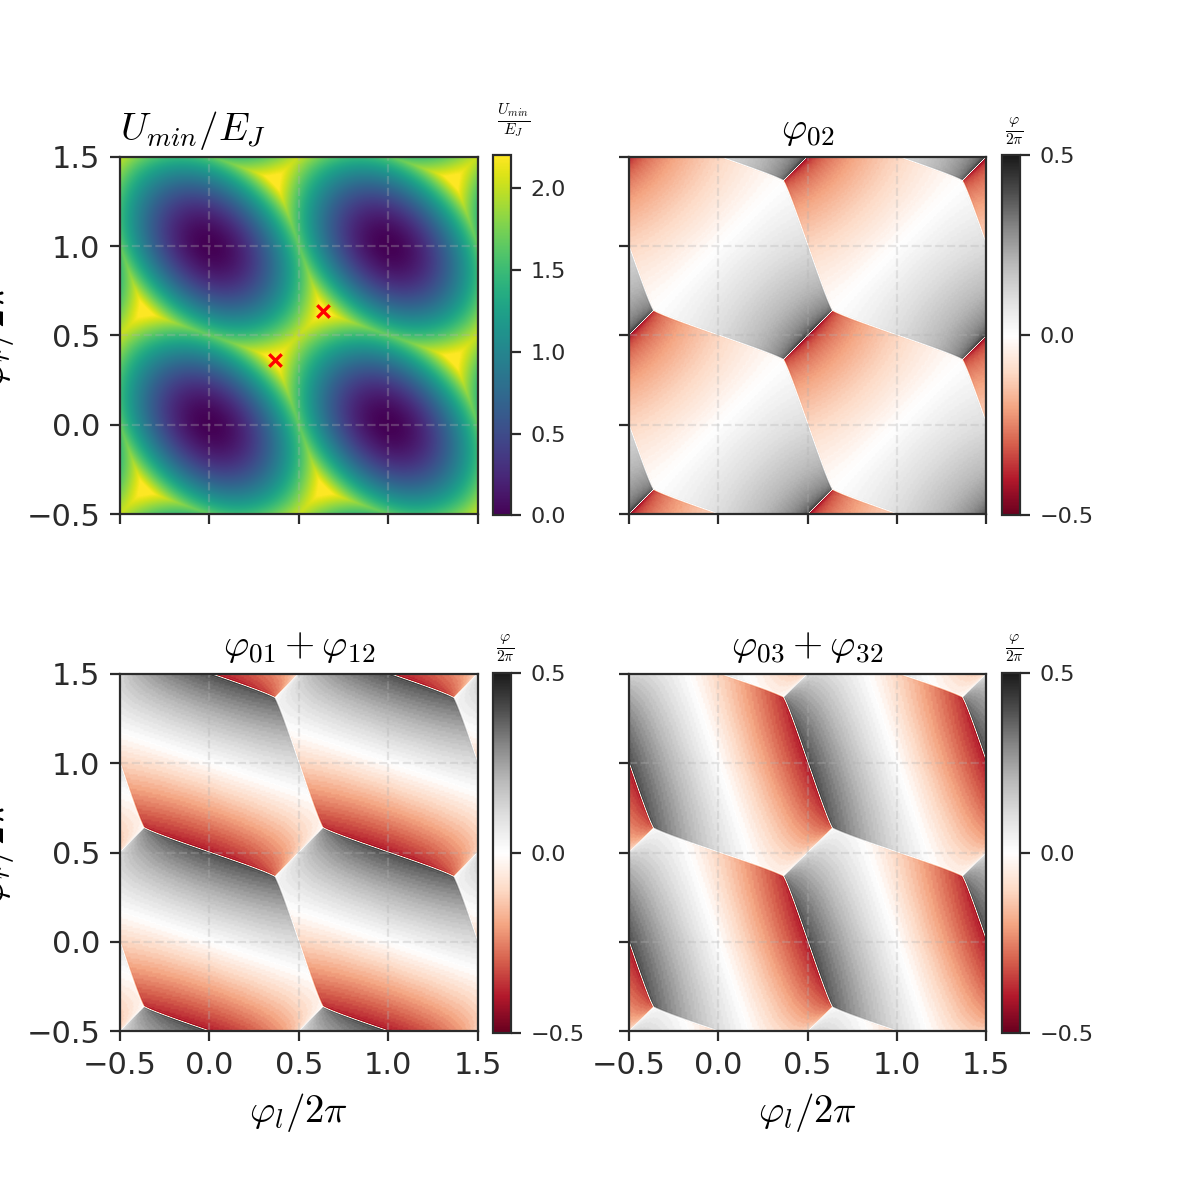

Text(0.5, 0, '$\\varphi_l/2\\pi$')

In [17]:
%matplotlib notebook
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
plt.subplots_adjust(left=0.1, bottom=None, right=0.85,
                    top=None, wspace=None, hspace=None)
cb = defaultdict(lambda: defaultdict(int))
im = defaultdict(lambda: defaultdict(int))

im[0][0] = ax[0][0].imshow(result["potential"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           interpolation='bessel',
                           vmin=0, vmax=2.2)
ax[0][0].set_title(r"$U_{min}/E_J$", fontsize=14, loc="left")

im[0][1] = ax[0][1].imshow(result["phi02"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           cmap='RdGy',
                           interpolation='bessel',
                           vmin=-0.5, vmax=0.5)
ax[0][1].set_title(r"$\varphi_{02}$", fontsize=14)

im[1][0] = ax[1][0].imshow(result["phi01"] + result["phi01"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           cmap='RdGy',
                           interpolation='bessel',
                           vmin=-0.5, vmax=0.5)
ax[1][0].set_title(r"$\varphi_{01} + \varphi_{12}$", fontsize=14)

im[1][1] = ax[1][1].imshow(result["phi03"] + result["phi03"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           cmap='RdGy',
                           interpolation='bessel',
                           vmin=-0.5, vmax=0.5)
ax[1][1].set_title(r"$\varphi_{03} + \varphi_{32}$", fontsize=14)

# Colorbars
for (i, j) in list(itertools.product([0, 1], [0, 1])):
    if i == 0 and j == 0:
        cb[i][j] = fig.colorbar(im[i][j], ax=ax[i][j],
                                fraction=0.046, pad=0.04)
        cb[i][j].ax.set_ylabel(
            r"$\frac{U_{min}}{E_J}$", fontsize=8, rotation=0, ha="left", labelpad=-25, y=1.15)
        cb[i][j].set_ticks([0, 0.5, 1, 1.5, 2])
    else:
        cb[i][j] = fig.colorbar(im[i][j], ax=ax[i][j],
                                fraction=0.046, pad=0.04)
        cb[i][j].ax.set_ylabel(
            r"$\frac{\varphi}{2\pi}$", fontsize=8, rotation=0, ha="left", labelpad=-32, y=1.11)
        cb[i][j].set_ticks([-0.5, 0, 0.5])
    cb[i][j].ax.tick_params(labelsize=8)
# Degeneracy
phiT0 = 2 * math.acos(math.sqrt(float(ALPHA ** 2 + 1)) - ALPHA) / (2 *  math.pi)
phiT1 = (2 * pi - 2 * math.acos(math.sqrt(float(ALPHA ** 2 + 1)) - ALPHA)) / (2 *  math.pi)
ax[0][0].scatter(float(phiT0), float(phiT0), marker='x', color='red', s=20)
ax[0][0].scatter(float(phiT1), float(phiT1), marker='x', color='red', s=20)

# X ticks
ax[0][0].set_xticks([-0.5, 0, 0.5, 1, 1.5])
# Axes Labels
ax[0][0].set_ylabel(r"$\varphi_r/2\pi$", fontsize=14)
ax[1][0].set_xlabel(r"$\varphi_l/2\pi$", fontsize=14)
ax[1][0].set_ylabel(r"$\varphi_r/2\pi$", fontsize=14)
ax[1][1].set_xlabel(r"$\varphi_l/2\pi$", fontsize=14)

In [18]:
plotter.save_onto_white_background(ax, "./output/potential_minimum_diamonds", "pdf")

## 3D Plot of potential

<IPython.core.display.Javascript object>


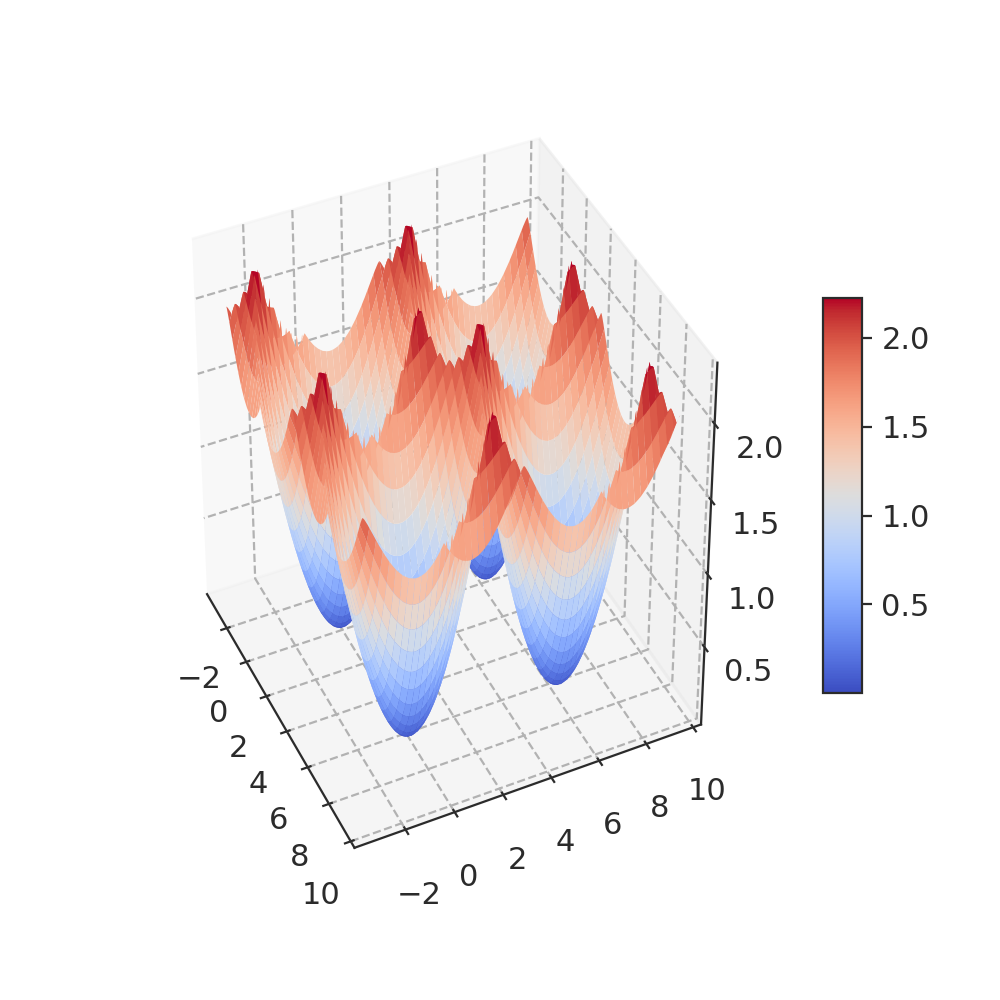

In [19]:
%matplotlib notebook

fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')

grid_x, grid_y = np.meshgrid(lr_array, lr_array)
surf = ax.plot_surface(grid_x, grid_y, 
                       result["potential"], 
                       #quadrants["potential"][0][0],
                       cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=10)

## Parabollic approximation comparisson
- Along $\varphi_l == \varphi_r$
- Along $\frac{\varphi_l + \varphi_r}{2} = \pi \equiv \varphi_+$ 

### Naive approximation
Just immediately expand the cosines, no thinking about if it is valid
$$\varphi_{02} \approx \frac{\varphi_l-\varphi_r - 2\pi(L-R)}{2(1+\alpha)}$$
$$\frac{U_\text{min}}{E_J}   \approx \left(\frac{\varphi_{02}   - \varphi_l + 2\pi L}{2}\right)^2 + \left(\frac{\varphi_{02} +  \varphi_r - 2\pi R}{2}\right)^2 + \frac{\alpha}{2}\varphi_{02}^2$$

In [20]:
def phi02_naive_approximation(phi_l: float, phi_r: float, L: int, R: int, alpha: float):
    return (phi_l - phi_r - 2 * pi * (L - R)) / (2 * (1 + alpha))


def potential_naive_approximation(phi02: float, phi_l: float, phi_r: float, L: int, R: int, alpha: float):
    
    #return ((phi02 - phi_l + 2 * pi * L)**2) / 4 + ((phi02 + phi_r - 2 * pi * R) ** 2 / 4) + alpha * phi02 # (alpha * phi02 ** 2) / 2
    
    return (phi02 - phi_l + 2 * pi * L) ** 2 / 4 + (phi02 + phi_r - 2 * pi * R) ** 2 / 4 + alpha * phi02 ** 2 / 2

In [21]:
potential_slice_naive = defaultdict(list)
alpha = 1

for phi_l_idx, phi_l in enumerate(lr_array):
    phi_r_idx = len(lr_array) - phi_l_idx - 1
    phi_r = lr_array[phi_r_idx]

    potential_slice_naive["potential_phi_plus"].append(
        result["potential"][phi_l_idx][phi_r_idx]
    )

    min_potential = None
    for (L, R) in itertools.permutations([-1, 0, 1], r=2):
        phi02 = phi02_naive_approximation(phi_l, phi_r, L, R, alpha)
        potential = potential_naive_approximation(
            phi02, phi_l, phi_r, L, R, alpha)

        if min_potential is None or potential < min_potential:
            min_potential = potential
        if L == 0 and R == 1:
            potential_slice_naive["potential_phi_approximation_01"].append(potential)
        if L == 1 and R == 0:
            potential_slice_naive["potential_phi_approximation_10"].append(potential)

    potential_slice_naive["potential_phi_approximation"].append(min_potential)

<IPython.core.display.Javascript object>


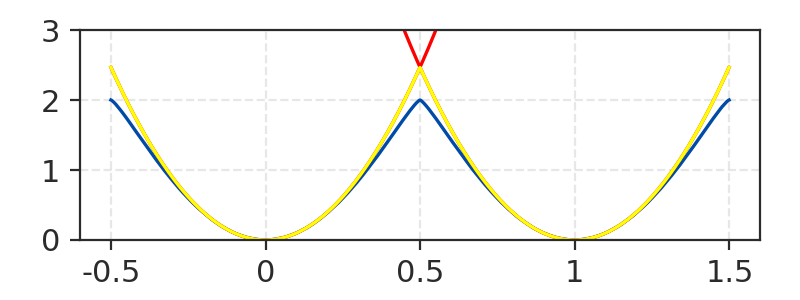

In [28]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=1, hspace=None)

ax.plot(potential_slice_naive["potential_phi_plus"])
ax.plot(potential_slice_naive["potential_phi_approximation_01"], color='red')
ax.plot(potential_slice_naive["potential_phi_approximation_10"], color='red')
ax.plot(potential_slice_naive["potential_phi_approximation"], color='yellow')


# X ticks
ax.set_xticks(list(np.linspace(0, NUMBER_OF_FIELD_POINTS, 5)))
ax.set_ylim([0, 3])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5])
None

### Thorough approximation with $\delta$ from the center
$$\frac{U_\text{min}}{E_J}   \approx\left(\frac{\varphi_{02} - \delta_l}{2}\right)^2 +  \left(\frac{\varphi_{02}+ \delta_r}{2}\right)^2 +
        \frac{\alpha}{2}\varphi_{02}^2$$
        
where we have deviations 
- $\delta_l=\varphi_l-2\pi    L$
- $\delta_r=\varphi_r-2\pi R$ 
- $\varphi_{02}   \approx  \frac{\delta_{l}   -  \delta_r}{2(1+\alpha)}$

from the center of cell $\{L,R\}$.

In [23]:
def potential_approximation(phi_l: float, phi_r: float, L: int, R: int, alpha: float):
    delta_l = phi_l - 2 * pi * L
    delta_r = phi_r - 2 * pi * R
    phi02 = (delta_l - delta_r) / (2 * (1 + alpha))

    #return ((phi_02 - delta_l) ** 2) / 4 + ((phi_02 + delta_r) ** 2) / 4 + alpha * phi02 #(alpha * phi02 ** 2) / 2
    
    return (phi02 - delta_l) ** 2 / 4 + (phi02 + delta_r) ** 2 / 4 + alpha * phi02 ** 2 / 2

In [24]:
potential_slice = defaultdict(list)
alpha = 1

for phi_l_idx, phi_l in enumerate(lr_array):
    phi_r_idx = len(lr_array) - phi_l_idx - 1
    phi_r = lr_array[phi_r_idx]

    potential_slice["potential_phi_plus"].append(
        result["potential"][phi_l_idx][phi_r_idx]
    )

    min_potential = None
    for (L, R) in itertools.permutations([-1, 0, 1], r=2):
        potential = potential_approximation(phi_l, phi_r, L, R, alpha)
        phi02 = phi02_naive_approximation(phi_l, phi_r, L, R, alpha)
        potential_naive = potential_naive_approximation(phi02, phi_l, phi_r, L, R, alpha)
        assert abs(potential - potential_naive) < 0.00000001, f"{potential}--{potential_naive}"

        if min_potential is None or potential < min_potential:
            min_potential = potential
        if L == 0 and R == 1:
            potential_slice["potential_phi_approximation_01"].append(potential)
        if L == 1 and R == 0:
            potential_slice["potential_phi_approximation_10"].append(potential)

    potential_slice["potential_phi_approximation"].append(min_potential)
print("done")

done


<IPython.core.display.Javascript object>


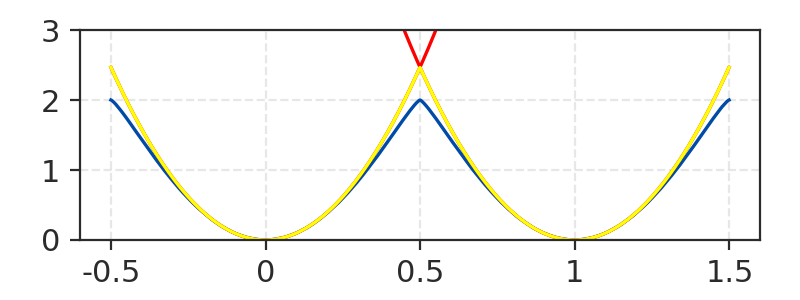

[Text(0, 0, '-0.5'),
 Text(0, 0, '0'),
 Text(0, 0, '0.5'),
 Text(0, 0, '1'),
 Text(0, 0, '1.5')]

In [30]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=1, hspace=None)

ax.plot(potential_slice["potential_phi_plus"])
ax.plot(potential_slice["potential_phi_approximation_01"], color='red')
ax.plot(potential_slice["potential_phi_approximation_10"], color='red')
ax.plot(potential_slice["potential_phi_approximation"], color='yellow')

# X ticks
ax.set_xticks(np.linspace(0, NUMBER_OF_FIELD_POINTS, 5))
ax.set_ylim([0, 3])
ax.set_xticklabels([-0.5, 0, 0.5, 1, 1.5])

# 2D Plot of potential
Investigate region around the degenreacy point

## Parameters

In [2]:
from kernels.potential_evaluated_in_phi02_phi01_plane import PotentialEvaluatedInPhi02Phi02Plane
from utils.info import allocate_max_threads, verify_blocks_per_grid

NUMBER_OF_PHI_POINTS_FOR_2D = 100
ALPHA_2D_plot = [0.8, 1, 1.2]
phi01_bounds = (-0.5, 0.5)
phi02_bounds = (0, 1)

phi01_array = np.linspace(2 * pi * phi01_bounds[0],
                          2 * pi * phi01_bounds[1], NUMBER_OF_PHI_POINTS_FOR_2D)
phi02_array = np.linspace(2 * pi * phi02_bounds[0],
                          2 * pi * phi02_bounds[1], NUMBER_OF_PHI_POINTS_FOR_2D)
phi03_array = np.linspace(2 * pi * phi01_bounds[0],
                          2 * pi * phi01_bounds[1], NUMBER_OF_PHI_POINTS_FOR_2D)

## Kernel creation

In [3]:
BLOCKS_PER_GRID_FOR_2D = (NUMBER_OF_PHI_POINTS_FOR_2D, NUMBER_OF_PHI_POINTS_FOR_2D)
verify_blocks_per_grid(BLOCKS_PER_GRID_FOR_2D)
THREADS_PER_BLOCK_FOR_2D = allocate_max_threads()

potential_evaluated_in_phi02_phi01_plane = PotentialEvaluatedInPhi02Phi02Plane(NUMBER_OF_PHI_POINTS_FOR_2D, potential_function_cuda)

🐳 Verified             BLOCKS_PER_GRID=(100, 100)
🐳 Allocating           THREADS_PER_BLOCK = (10, 10, 10)


## Array allocation on GPU

In [4]:
DEVICE_phi01_array = cuda.to_device(phi01_array)
DEVICE_phi02_array = cuda.to_device(phi02_array)
DEVICE_phi03_array = cuda.to_device(phi03_array)

DEVICE_output_2d_plot = cuda.device_array(
    shape=(NUMBER_OF_PHI_POINTS_FOR_2D, NUMBER_OF_PHI_POINTS_FOR_2D),
    dtype=np.float64,
)

## Running

In [5]:
output_2d_plot = {}
for alpha in ALPHA_2D_plot:
    potential_evaluated_in_phi02_phi01_plane.kernel[BLOCKS_PER_GRID_FOR_2D, THREADS_PER_BLOCK_FOR_2D](
        DEVICE_phi01_array,
        DEVICE_phi02_array,
        DEVICE_phi03_array,
        pi,
        pi,
        alpha,
        DEVICE_output_2d_plot,
    )
    output_2d_plot[f"{int(10*alpha)}"] = (DEVICE_output_2d_plot.copy_to_host())

## Post processing
Now minimise $U(\varphi_{01}, \varphi_{02})$ with respect to $\varphi_{01}$


### Warning
Remember! Matplotlib is retarded!
If you give it an array (100,20), it will plot:
- 100 points along the y axis  **(idx0=100 is for the y axis)** 100 rows
- 20 points along the x axis   **(idx1=20 is for the x axis)** 20 columns


Therefore for searching the minimal value at each x value, you need to search the top-level axis=1
### Because of this, a reflection will be needed for further x-y things plotted onto it

In [17]:
def reflect_in_line(x_array: List[float], y_array: List[float],
                        m: float, c: float) -> Tuple[List[float], List[float]]:
    """Takes arrays of x-y pairs and reflects them about
            y = mx + c
    shift -> reflection in line -> -shift
    """
    reflection_matrix = np.matrix([[1 - m**2, 2 * m],
                                   [2 * m, m**2 - 1]]) / (1 + m**2)

    x_list, y_list = [], []
    for (x, y) in zip(x_array, y_array):
        vec = np.array([x, y]) - np.array([0, c])
        vec = reflection_matrix.dot(vec)
        vec = vec.tolist()[0]
        vec = vec + np.array([0, c])
        x_list.append(vec[0])
        y_list.append(vec[1])
    return (np.array(x_list), np.array(y_list))

In [18]:
plt.contourf(
    phi02_array / (2 * pi),
    phi01_array / (2 * pi),
    output_2d_plot["10"],
    levels=25,
    origin=None,
    vmin=2, vmax=6)

phi02_plot, phi01_plot = reflect_in_line(
    phi02_array / (2 * pi),
    phi01_array[np.argmin(
        output_2d_plot["10"], axis=1)] / (2 * pi),
    m=1,
    c=-0.5)

plt.scatter(phi02_plot, phi01_plot)
plt.show()

### Run the search

In [80]:
potential_minimised_wrt_phi01_phi03 = defaultdict(lambda: defaultdict(int))

for (key, potential_array) in output_2d_plot.items():
    min_indexes = np.argmin(potential_array, axis=1)    

    potential_minimised_wrt_phi01_phi03[key]["potential"] = np.min(potential_array, axis=1)
    (phi02_plot, phi01_plot) = reflect_in_line(
        phi02_array, phi01_array[min_indexes], m=1, c=-0.5 * (2 * pi))
    potential_minimised_wrt_phi01_phi03[key]["phi01_plot"] = phi01_plot
    potential_minimised_wrt_phi01_phi03[key]["phi02_plot"] = phi02_plot

## Plotting
**Note that in the array**
- phi02 runs along index=1
- phi01 runs along index=0

<IPython.core.display.Javascript object>


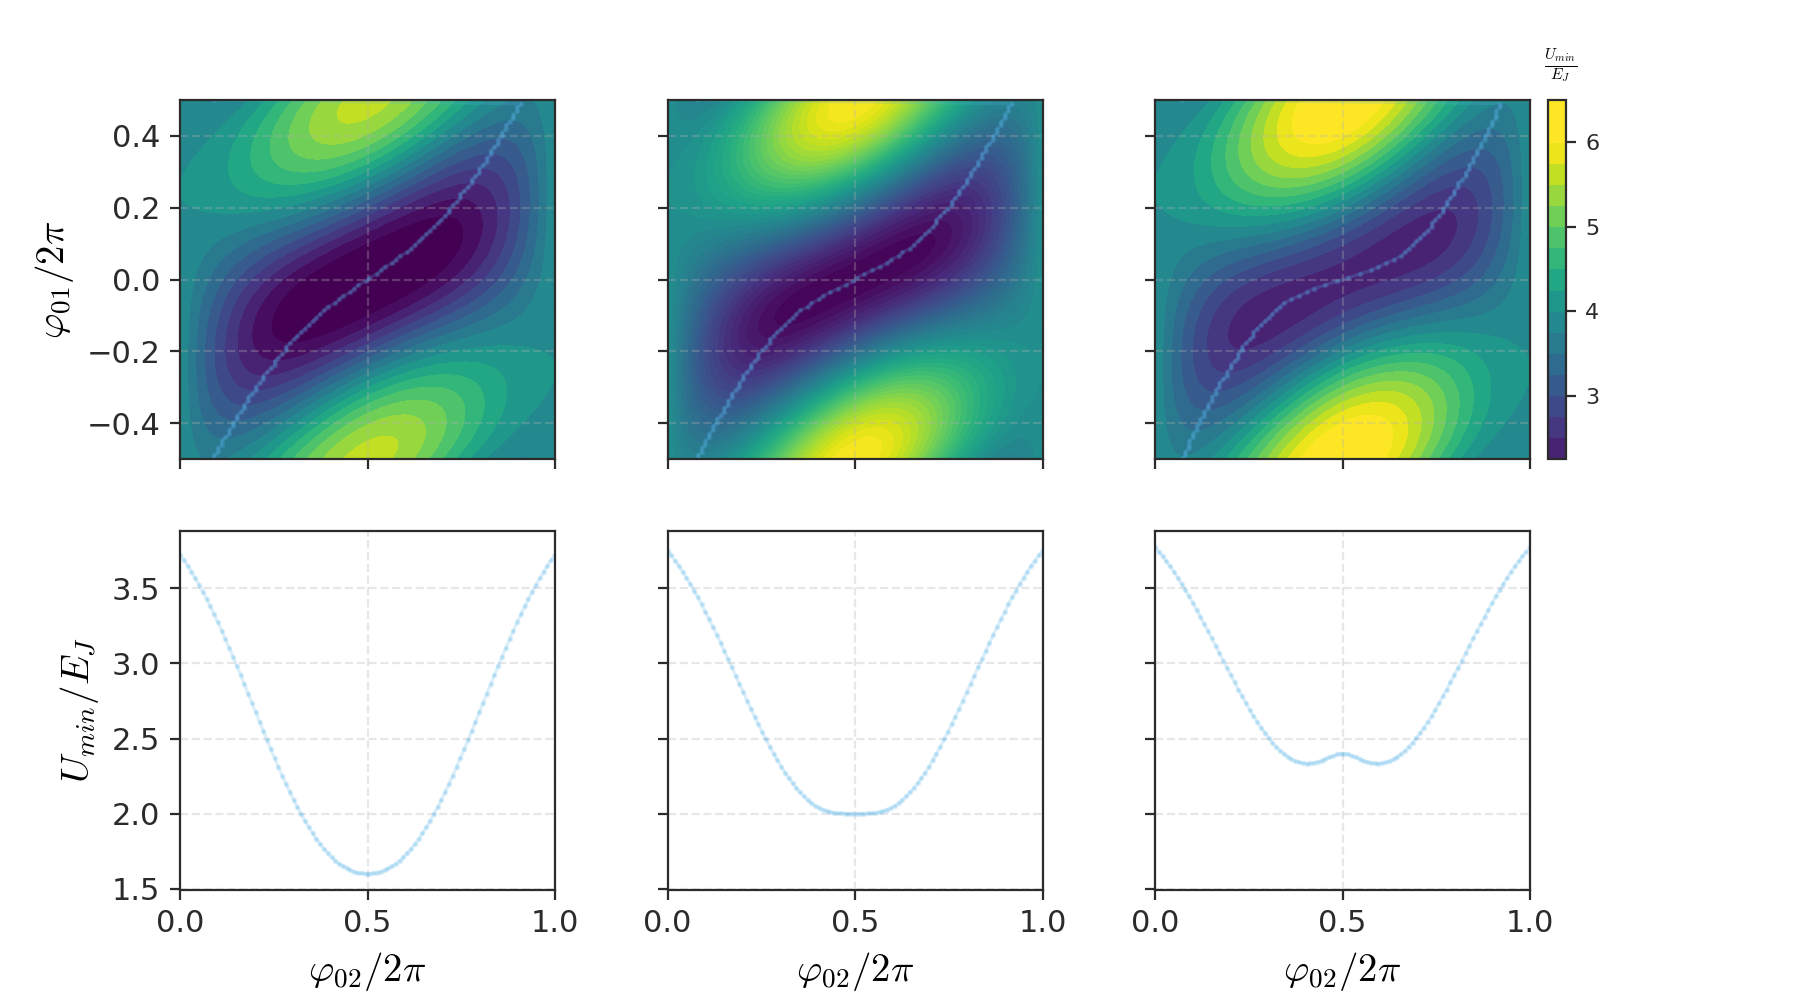

Text(0, 0.5, '$U_{min}/E_J$')

In [81]:
%matplotlib notebook

fig = plt.figure(figsize=(9,5))
ax = defaultdict(lambda: defaultdict(int))
ax[0][0] = fig.add_subplot(2,3,1)
ax[0][1] = fig.add_subplot(2,3,2, sharey=ax[0][0])
ax[0][2] = fig.add_subplot(2,3,3, sharey=ax[0][1])
ax[0][0].tick_params(labelbottom=False)
ax[0][1].tick_params(labelleft=False)
ax[0][1].tick_params(labelbottom=False)
ax[0][2].tick_params(labelleft=False)
ax[0][2].tick_params(labelbottom=False)
ax[1][0] = fig.add_subplot(2,3,4, sharex=ax[0][0])
ax[1][1] = fig.add_subplot(2,3,5, sharex=ax[0][1], sharey=ax[1][0])
ax[1][2] = fig.add_subplot(2,3,6, sharex=ax[0][2], sharey=ax[1][0])
ax[1][1].tick_params(labelleft=False)
ax[1][2].tick_params(labelleft=False)

plt.subplots_adjust(left=0.1, bottom=None, right=0.85,
                    top=None, wspace=None, hspace=None)
cb = defaultdict(lambda: defaultdict(int))
im = defaultdict(lambda: defaultdict(int))

im[0][0] = ax[0][0].contourf(phi02_array / (2 * pi), phi01_array /
                       (2 * pi), output_2d_plot["8"], levels=18,
                       origin='lower',
                       vmin=2, vmax=6)
ax[0][0].plot(
    potential_minimised_wrt_phi01_phi03["8"]["phi02_plot"] / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["8"]["phi01_plot"] / (2 * pi),
    color='C2', marker='.', alpha=0.2
)
ax[1][0].plot(
    phi02_array / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["8"]["potential"],
    color='C2', marker='.', alpha=0.2
)

im[0][1] = ax[0][1].contourf(phi02_array / (2 * pi), phi01_array /
                       (2 * pi), output_2d_plot["10"], levels=40,
                       origin='lower',
                       vmin=2, vmax=6)
ax[0][1].plot(
    potential_minimised_wrt_phi01_phi03["10"]["phi02_plot"] / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["10"]["phi01_plot"] / (2 * pi),
    color='C2', marker='.', alpha=0.2
)
ax[1][1].plot(
    phi02_array / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["10"]["potential"],
    color='C2', marker='.', alpha=0.2
)

im[0][2] = ax[0][2].contourf(phi02_array / (2 * pi), phi01_array /
                       (2 * pi), output_2d_plot["12"], levels=18,
                       origin='lower',
                       vmin=2, vmax=6)
ax[0][2].plot(
    potential_minimised_wrt_phi01_phi03["12"]["phi02_plot"] / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["12"]["phi01_plot"] / (2 * pi),
    color='C2', marker='.', alpha=0.2
)
ax[1][2].plot(
    phi02_array / (2 * pi), 
    potential_minimised_wrt_phi01_phi03["12"]["potential"],
    color='C2', marker='.', alpha=0.2
)

#Magic for extra axes to put colorbar
(x0, y0, width, height) = ax[0][2].get_position().bounds
(w_pad, h_pad, wspace, hspace) = fig.get_constrained_layout_pads()
cb_axes = fig.add_axes([x0 + width + wspace / 2, y0, wspace, height])
cb_axes.set_visible(False)
cb = fig.colorbar(im[0][2], ax=cb_axes,
                 fraction=1
                 )
cb.ax.set_ylabel(
    r"$\frac{U_{min}}{E_J}$", fontsize=8, rotation=0, ha="left", labelpad=-20, y=1.15)
cb.ax.tick_params(labelsize=8)
cb.set_ticks([3, 4, 5, 6])

# Axes labels
for i in range(0, 3):
    ax[1][i].set_xticks([0, 0.5, 1.0])
    ax[1][i].set_xlabel(r"$\varphi_{02}/2\pi$", fontsize=14)
ax[0][0].set_ylabel(r"$\varphi_{01}/2\pi$", fontsize=14)
ax[1][0].set_ylabel(r"$U_{min}/E_J$", fontsize=14)

In [ ]:
im[0][1] = ax[0][1].imshow(result["phi02"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           cmap='RdGy',
                           interpolation='bessel',
                           vmin=-0.5, vmax=0.5)
ax[0][1].set_title(r"$\varphi_{02}$", fontsize=14)

im[1][0] = ax[1][0].imshow(result["phi01"] + result["phi01"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           cmap='RdGy',
                           interpolation='bessel',
                           vmin=-0.5, vmax=0.5)
ax[1][0].set_title(r"$\varphi_{01} + \varphi_{12}$", fontsize=14)

im[1][1] = ax[1][1].imshow(result["phi03"] + result["phi03"],
                           extent=[LOWER, UPPER, LOWER, UPPER],
                           origin='lower',
                           cmap='RdGy',
                           interpolation='bessel',
                           vmin=-0.5, vmax=0.5)
ax[1][1].set_title(r"$\varphi_{03} + \varphi_{32}$", fontsize=14)

# Colorbars
for (i, j) in list(itertools.product([0, 1], [0, 1])):
    if i == 0 and j == 0:
        cb[i][j] = fig.colorbar(im[i][j], ax=ax[i][j],
                                fraction=0.046, pad=0.04)
        cb[i][j].ax.set_ylabel(
            r"$\frac{U_{min}}{E_J}$", fontsize=8, rotation=0, ha="left", labelpad=-25, y=1.15)
        cb[i][j].set_ticks([0, 0.5, 1, 1.5, 2])
    else:
        cb[i][j] = fig.colorbar(im[i][j], ax=ax[i][j],
                                fraction=0.046, pad=0.04)
        cb[i][j].ax.set_ylabel(
            r"$\frac{\varphi}{2\pi}$", fontsize=8, rotation=0, ha="left", labelpad=-32, y=1.11)
        cb[i][j].set_ticks([-0.5, 0, 0.5])
    cb[i][j].ax.tick_params(labelsize=8)
# Degeneracy
phiT0 = 2 * math.acos(math.sqrt(float(ALPHA ** 2 + 1)) - ALPHA) / (2 *  math.pi)
phiT1 = (2 * pi - 2 * math.acos(math.sqrt(float(ALPHA ** 2 + 1)) - ALPHA)) / (2 *  math.pi)
ax[0][0].scatter(float(phiT0), float(phiT0), marker='x', color='red', s=20)
ax[0][0].scatter(float(phiT1), float(phiT1), marker='x', color='red', s=20)

# X ticks
ax[0][0].set_xticks([-0.5, 0, 0.5, 1, 1.5])
# Axes Labels
ax[0][0].set_ylabel(r"$\varphi_r/2\pi$", fontsize=14)
ax[1][0].set_xlabel(r"$\varphi_l/2\pi$", fontsize=14)
ax[1][0].set_ylabel(r"$\varphi_r/2\pi$", fontsize=14)
ax[1][1].set_xlabel(r"$\varphi_l/2\pi$", fontsize=14)